<a href="https://www.kaggle.com/code/shivambhatt26/association-rule-mining?scriptVersionId=222938332" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1>IMPORTS & SETUP</h1>

In [1]:
# =============================================================================
# 1. IMPORTS & SETUP
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Imbalanced learning
from imblearn.under_sampling import NearMiss

# Association rule mining libraries
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Graph visualization
import networkx as nx

# Other utilities
from collections import defaultdict
from itertools import combinations
from pandas.plotting import parallel_coordinates

<h2>DATA LOADING AND MERGING</h2>

In [2]:
# =============================================================================
# 2. DATA LOADING AND MERGING
# =============================================================================
# Load the Pima Indians Diabetes dataset
df_pima = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')

# Load the three Health Indicators datasets
file1 = pd.read_csv('/kaggle/input/diabetes-health-indicators-dataset/diabetes_012_health_indicators_BRFSS2015.csv')
file2 = pd.read_csv("/kaggle/input/diabetes-health-indicators-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
file3 = pd.read_csv('/kaggle/input/diabetes-health-indicators-dataset/diabetes_binary_health_indicators_BRFSS2015.csv')

# Add a source column for identification
file1['Source'] = 'file1'
file2['Source'] = 'file2'
file3['Source'] = 'file3'

# Convert target variable in file1 from Diabetes_012 to binary (0: healthy, 1: diabetic)
file1['Diabetes_binary'] = file1['Diabetes_012'].apply(lambda x: 1 if x >= 1 else 0)
file1 = file1.drop(columns=['Diabetes_012'])

# For file2 and file3, the target is already binary
# Merge the three files into one dataset
df_health = pd.concat([file1, file2, file3], ignore_index=True)
df_health = df_health.drop(columns=['Source'])  # Drop the helper column

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<h2>EXPLORATORY DATA ANALYSIS (EDA)</h2>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Pima Dataset Shape: (768, 9)
Health Dataset Shape: (578052, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578052 entries, 0 to 578051
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ---

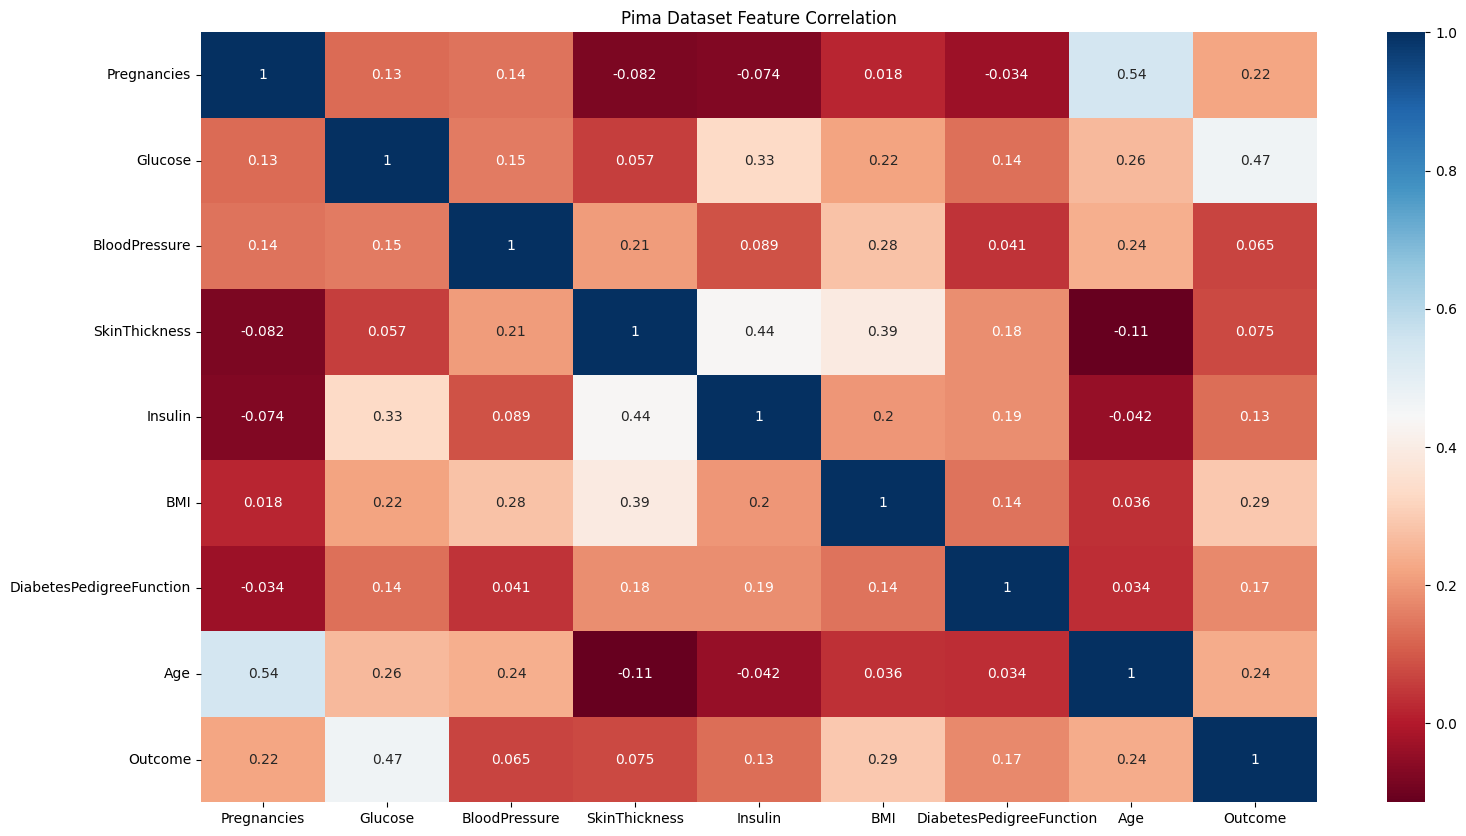

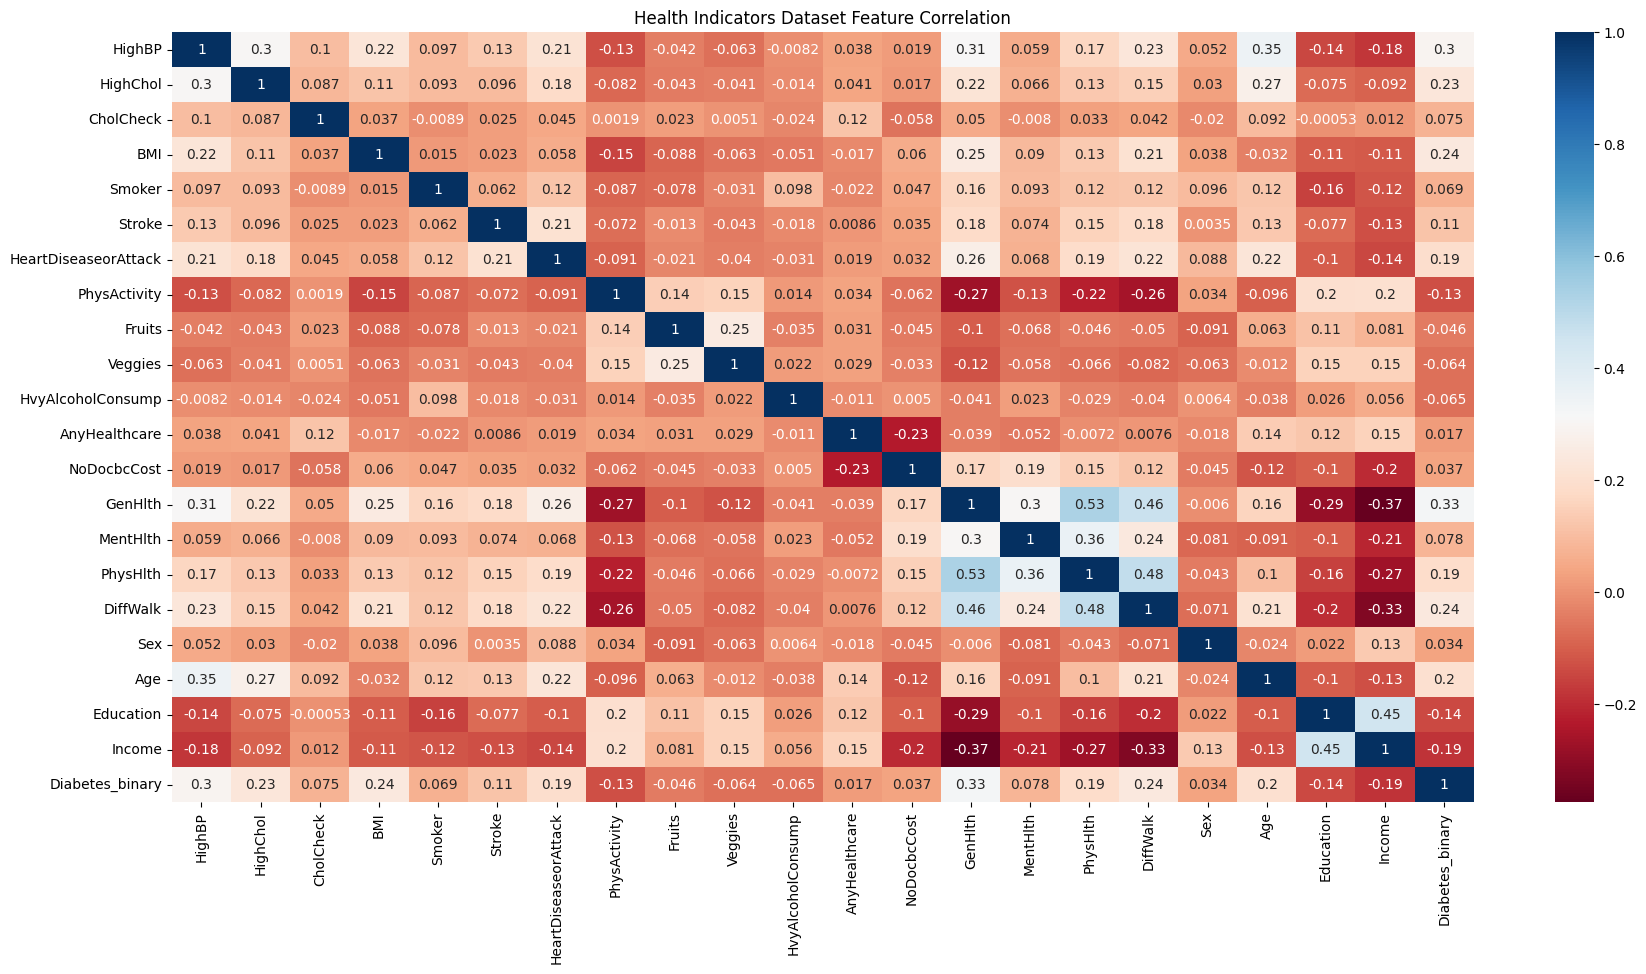

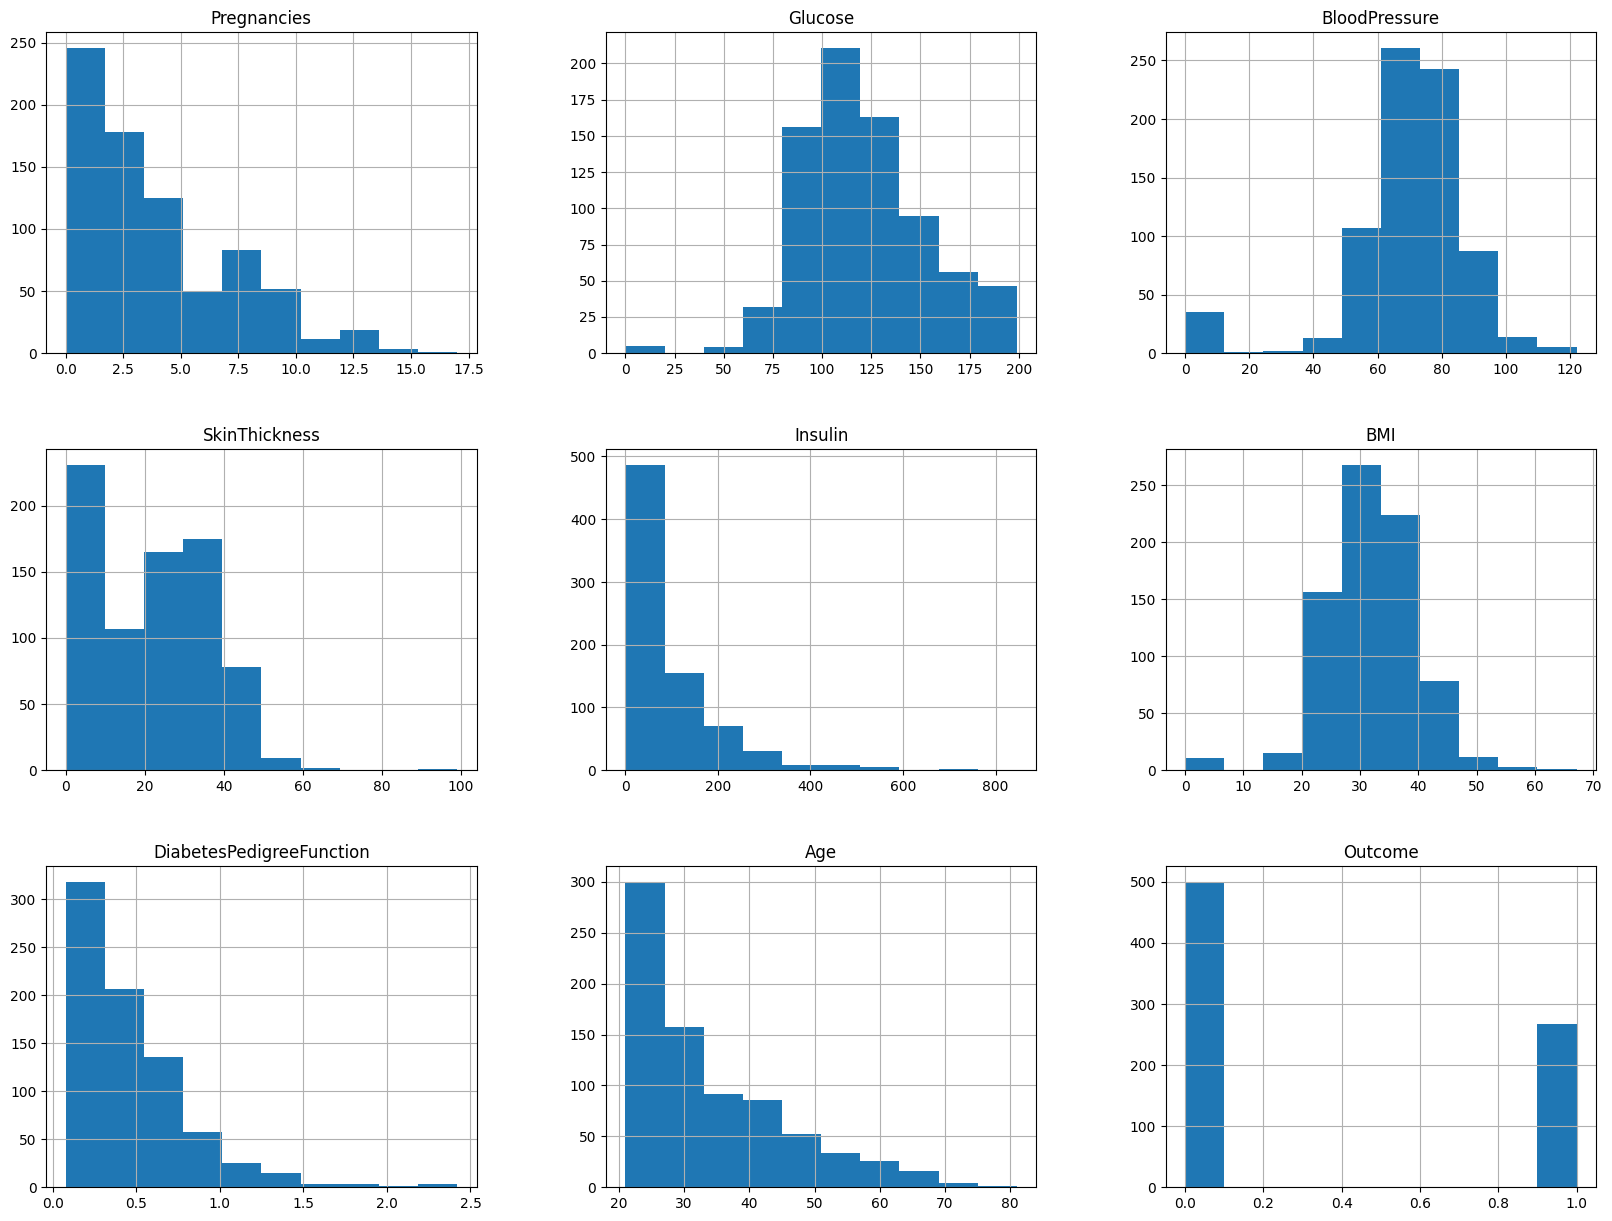

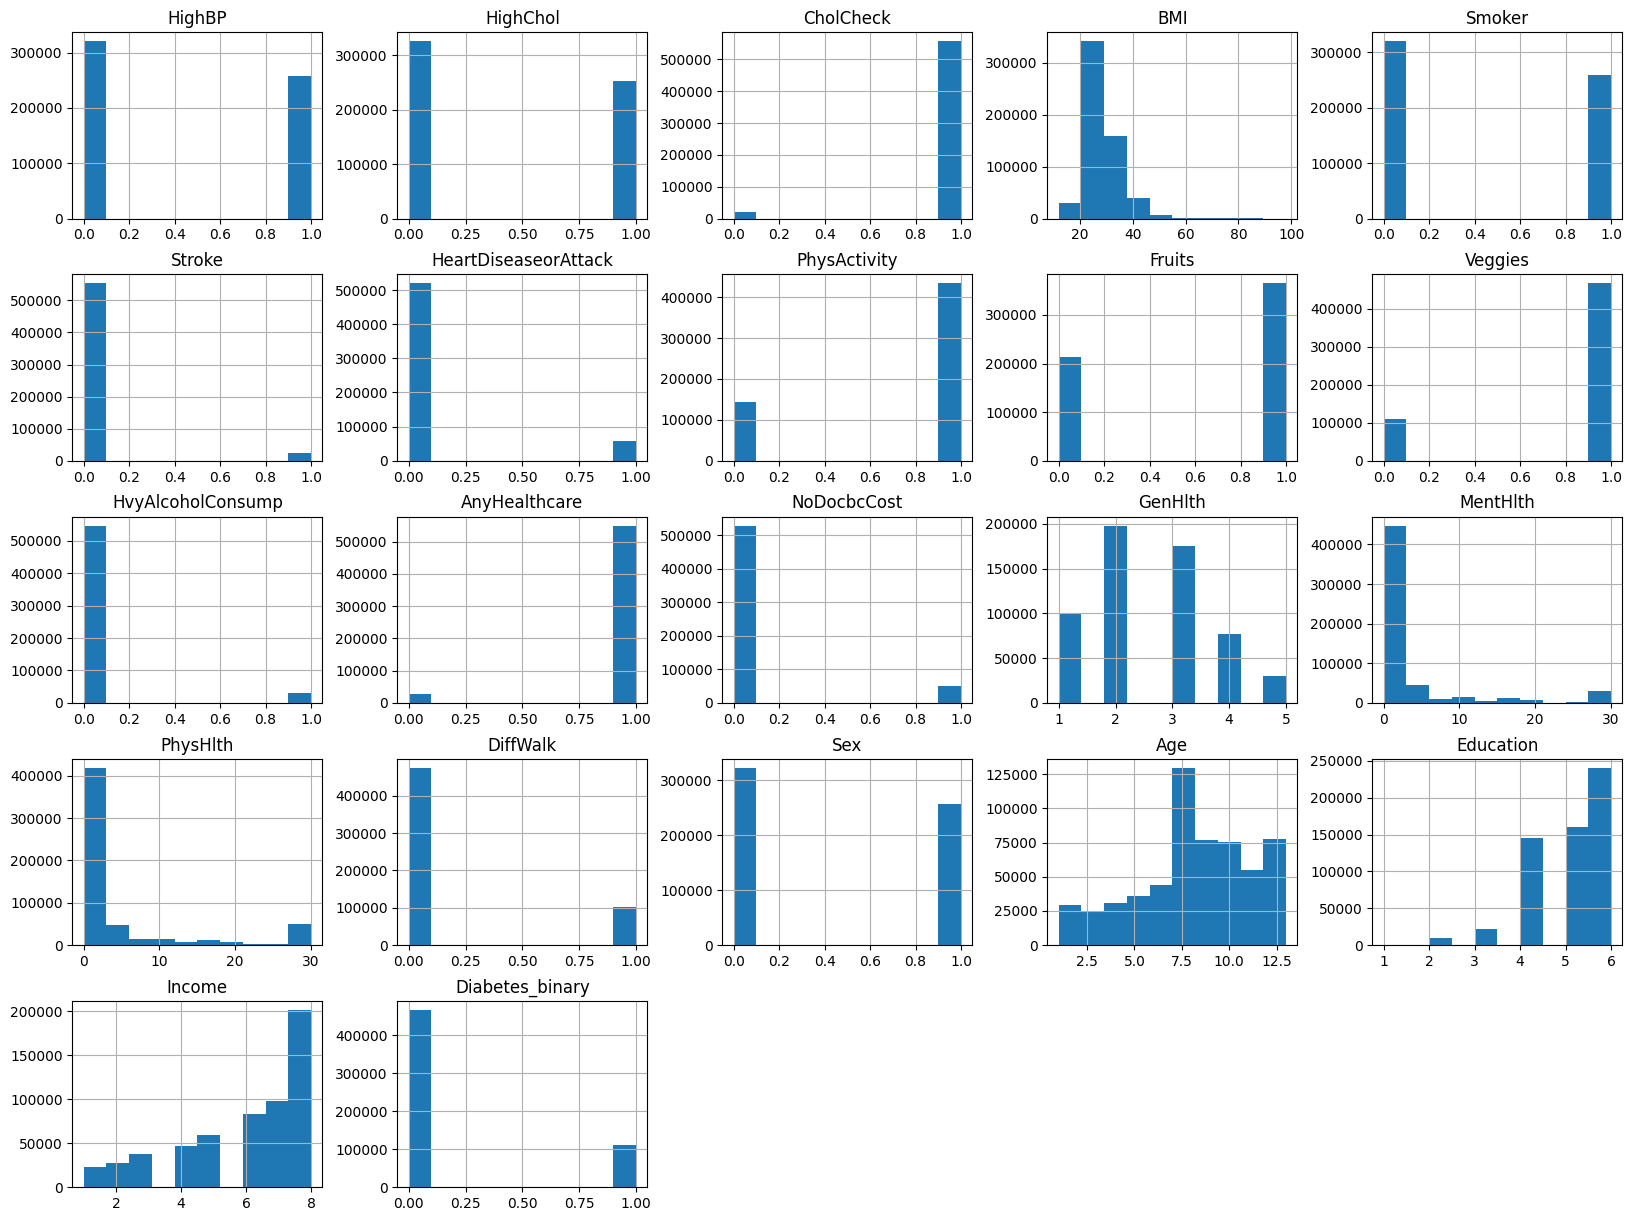

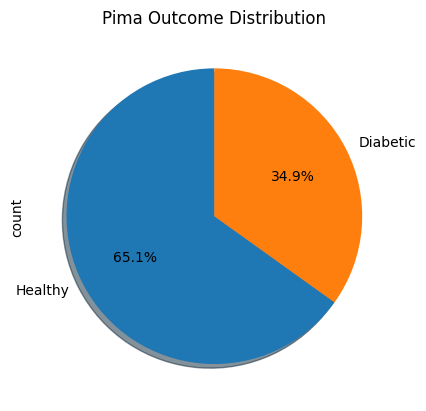

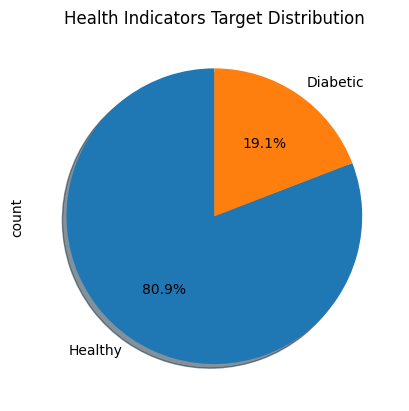

In [3]:
# =============================================================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================
# Display basic info
print("Pima Dataset Shape:", df_pima.shape)
print("Health Dataset Shape:", df_health.shape)
print(df_pima.info())
print(df_health.info())

# Correlation heatmaps
plt.figure(figsize=(18, 10))
sns.heatmap(df_pima.corr(), annot=True, cmap='RdBu')
plt.title("Pima Dataset Feature Correlation")
plt.show()

plt.figure(figsize=(21, 10))
sns.heatmap(df_health.corr(), annot=True, cmap='RdBu')
plt.title("Health Indicators Dataset Feature Correlation")
plt.show()

# Histograms for feature distributions
df_pima.hist(figsize=(20, 15))
plt.show()

df_health.hist(figsize=(20, 15))
plt.show()

# Pie charts for target variable distribution
plt.figure()
df_pima.Outcome.value_counts().plot.pie(labels=['Healthy', 'Diabetic'], autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Pima Outcome Distribution")
plt.show()

plt.figure()
df_health.Diabetes_binary.value_counts().plot.pie(labels=['Healthy', 'Diabetic'], autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Health Indicators Target Distribution")
plt.show()

<h2>PREPROCESSING</h2>

<h4>Handling Imbalance for Health Dataset using NearMiss</h4>

In [4]:
# =============================================================================
# 4. PREPROCESSING
# =============================================================================
# ---- 4.1 Handling Imbalance for Health Dataset using NearMiss ----
df_health_features = df_health.drop("Diabetes_binary", axis=1)
df_health_target = df_health["Diabetes_binary"]
print("Original Health Target Distribution:\n", df_health_target.value_counts())

nm = NearMiss(version=1, n_neighbors=10)
df_health_features, df_health_target = nm.fit_resample(df_health_features, df_health_target)
print("After Resampling, features shape:", df_health_features.shape)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be remo

Original Health Target Distribution:
 Diabetes_binary
0.0    467383
1.0    110669
Name: count, dtype: int64
After Resampling, features shape: (221338, 21)


<h4>Remove Duplicates</h4>

In [5]:
# ---- 4.2 Remove Duplicates ----
print("Duplicates in Pima:", df_pima.duplicated().sum())
print("Duplicates in Health:", df_health.duplicated().sum())
df_health.drop_duplicates(inplace=True)
print("Duplicates in Health after dropping:", df_health.duplicated().sum())

Duplicates in Pima: 0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Duplicates in Health: 344018
Duplicates in Health after dropping: 0


<h4>Preprocessing Function (Missing Values, Encoding, Scaling)</h4>

In [6]:
# ---- 4.3 Preprocessing Function (Missing Values, Encoding, Scaling) ----
def preprocess_data(df):
    # Fill missing values with median
    df = df.fillna(df.median())
    
    # Encode categorical variables
    label_encoders = {}
    for column in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
    
    # Normalize numeric features
    scaler = StandardScaler()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    
    return df

# Preprocess both datasets
pima_processed = preprocess_data(df_pima)
health_processed = preprocess_data(df_health)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated a

<h4>Separate Features and Target & Train-Test Split</h4>

In [7]:
# ---- 4.4 Separate Features and Target & Train-Test Split ----
def split_features_target(df, target_column):
    X = df.drop(target_column, axis=1)
    y = df[target_column].astype(int)
    return X, y

# For Pima dataset (target: "Outcome") and Health dataset (target: "Diabetes_binary")
X_pima, y_pima = split_features_target(pima_processed, "Outcome")
X_health, y_health = split_features_target(health_processed, "Diabetes_binary")

# Split each into training and test sets
X_pima_train, X_pima_test, y_pima_train, y_pima_test = train_test_split(X_pima, y_pima, test_size=0.2, random_state=42)
X_health_train, X_health_test, y_health_train, y_health_test = train_test_split(X_health, y_health, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<h2>MODEL TRAINING AND EVALUATION (RANDOM FOREST)</h2>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated a


Performance Metrics for Pima Indians Diabetes Dataset:
Accuracy: 0.7272727272727273
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79        99
           1       0.62      0.62      0.62        55

    accuracy                           0.73       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154



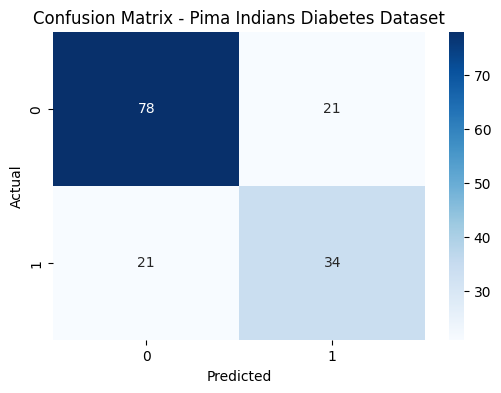

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



Performance Metrics for Health Indicators Dataset:
Accuracy: 0.8132116991048347
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89     38961
           2       0.37      0.17      0.23      7846

    accuracy                           0.81     46807
   macro avg       0.61      0.56      0.56     46807
weighted avg       0.77      0.81      0.78     46807



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

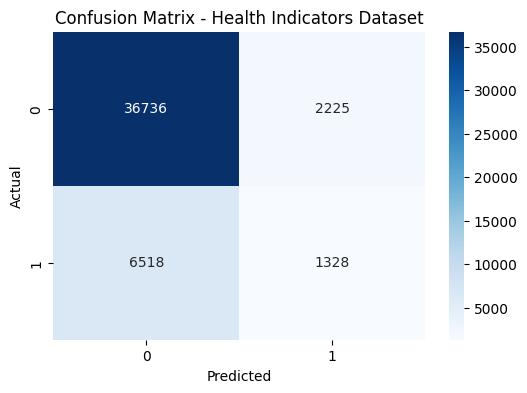

In [8]:
# =============================================================================
# 5. MODEL TRAINING AND EVALUATION (RANDOM FOREST)
# =============================================================================
def train_and_evaluate(X_train, X_test, y_train, y_test, dataset_name):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\nPerformance Metrics for {dataset_name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Evaluate on both datasets
train_and_evaluate(X_pima_train, X_pima_test, y_pima_train, y_pima_test, "Pima Indians Diabetes Dataset")
train_and_evaluate(X_health_train, X_health_test, y_health_train, y_health_test, "Health Indicators Dataset")


<h2>ASSOCIATION RULE MINING</h2>

<h4>Utility Functions for Association Rule Mining </h4>

In [9]:
# =============================================================================
# 6. ASSOCIATION RULE MINING
# =============================================================================
# --- 6.1 Utility Functions for Association Rule Mining ---
def convert_to_categorical(df, bins=3):
    """Convert numeric features to categorical bins."""
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = pd.qcut(df[col], q=bins, duplicates='drop').astype(str)
    return df

def prepare_data_for_rule_mining(df, target_column):
    """Prepare one-hot encoded data for association rule mining (drop target)."""
    df_categorical = convert_to_categorical(df.copy())
    df_categorical.drop(columns=[target_column], inplace=True)
    df_encoded = pd.get_dummies(df_categorical)
    return df_encoded

def visualize_rules(rules, top_n=10):
    """Visualize top rules by lift using a barplot."""
    plt.figure(figsize=(10, 6))
    sorted_rules = rules.sort_values(by="lift", ascending=False).head(top_n)
    sns.barplot(x="lift", y="consequents", data=sorted_rules, palette="viridis")
    plt.title("Top Association Rules by Lift")
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<h4>Apriori on Pima Dataset</h4>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



--- Apriori on Pima Dataset ---
                                  antecedents  \
0                   (Glucose_(-0.497, 0.285])   
1               (Pregnancies_(-0.548, 0.343])   
2                    (Glucose_(0.285, 2.444])   
3               (Pregnancies_(-0.548, 0.343])   
4               (Pregnancies_(-0.548, 0.343])   
...                                       ...   
3217         (BloodPressure_(-3.574, -0.161])   
3218                (Insulin_(-0.694, 0.126])   
3219                   (Age_(-1.043, -0.701])   
3220  (Glucose_(-3.7849999999999997, -0.497])   
3221                   (BMI_(-4.061, -0.393])   

                                            consequents  antecedent support  \
0                         (Pregnancies_(-0.548, 0.343])            0.329427   
1                             (Glucose_(-0.497, 0.285])            0.260417   
2                         (Pregnancies_(-0.548, 0.343])            0.326823   
3                              (Glucose_(0.285, 2.444])       

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


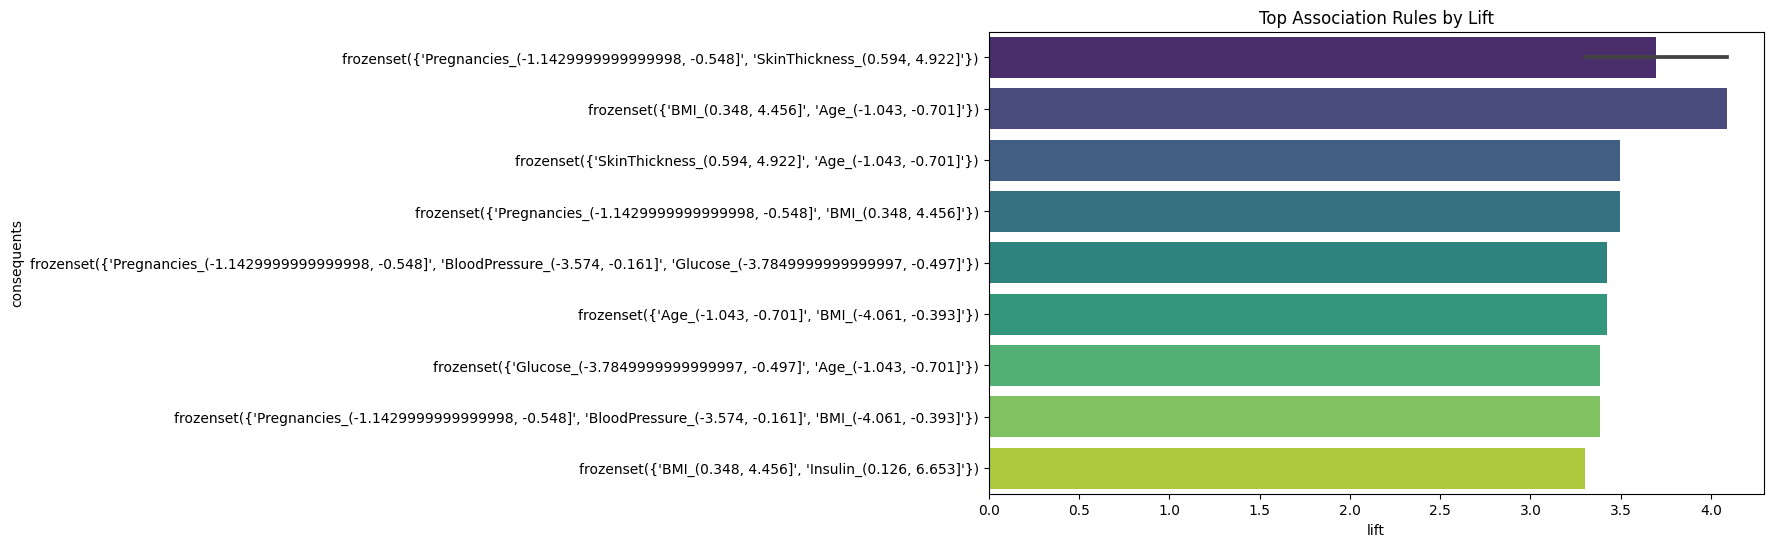

In [10]:
# --- 6.2 Apriori on Pima Dataset ---
print("\n--- Apriori on Pima Dataset ---")
df_encoded_pima = prepare_data_for_rule_mining(pima_processed, "Outcome")
frequent_itemsets_apriori = apriori(df_encoded_pima, min_support=0.05, use_colnames=True)
num_itemsets = len(frequent_itemsets_apriori)
rules_pima_apriori = association_rules(frequent_itemsets_apriori, num_itemsets, metric="lift", min_threshold=1.0)
print(rules_pima_apriori)
visualize_rules(rules_pima_apriori)

<h4>Apriori to the Health Dataset</h4>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-11-daa7e0ba3082>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  health_binarized = health_processed.applymap(lambda x: 1 if x > threshold else 0)


Sample transactions:
[['HighBP', 'HighChol', 'BMI', 'Smoker', 'Veggies', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk'], ['Smoker', 'PhysActivity', 'NoDocbcCost', 'Education'], ['HighBP', 'HighChol', 'Fruits', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Income'], ['HighBP', 'PhysActivity', 'Fruits', 'Veggies', 'Age'], ['HighBP', 'HighChol', 'PhysActivity', 'Fruits', 'Veggies', 'Age']]
One-hot encoded data:
     Age    BMI  Diabetes_binary  DiffWalk  Education  Fruits  GenHlth  \
0  False   True            False      True      False   False     True   
1  False  False            False     False       True   False    False   
2  False  False            False      True      False    True     True   
3   True  False            False     False      False    True    False   
4   True  False            False     False      False    True    False   

   HeartDiseaseorAttack  HighBP  HighChol  HvyAlcoholConsump  Income  \
0                 False    True      True             

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


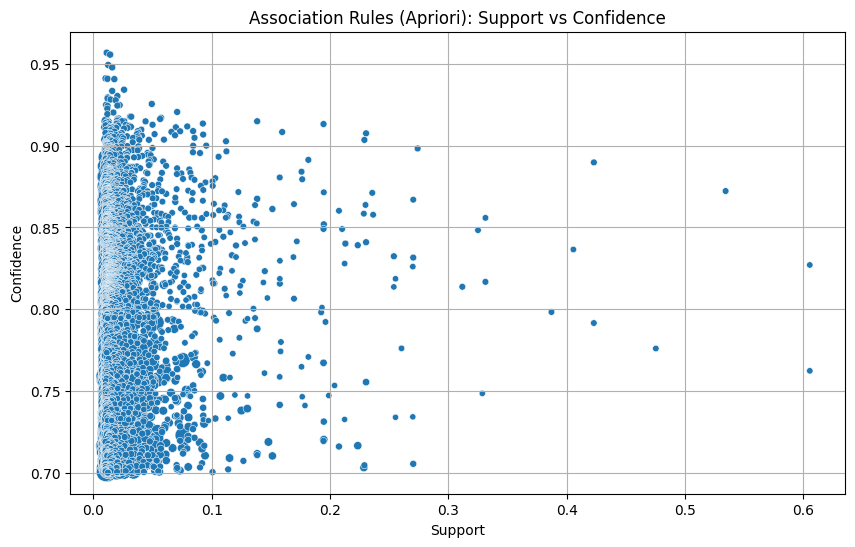

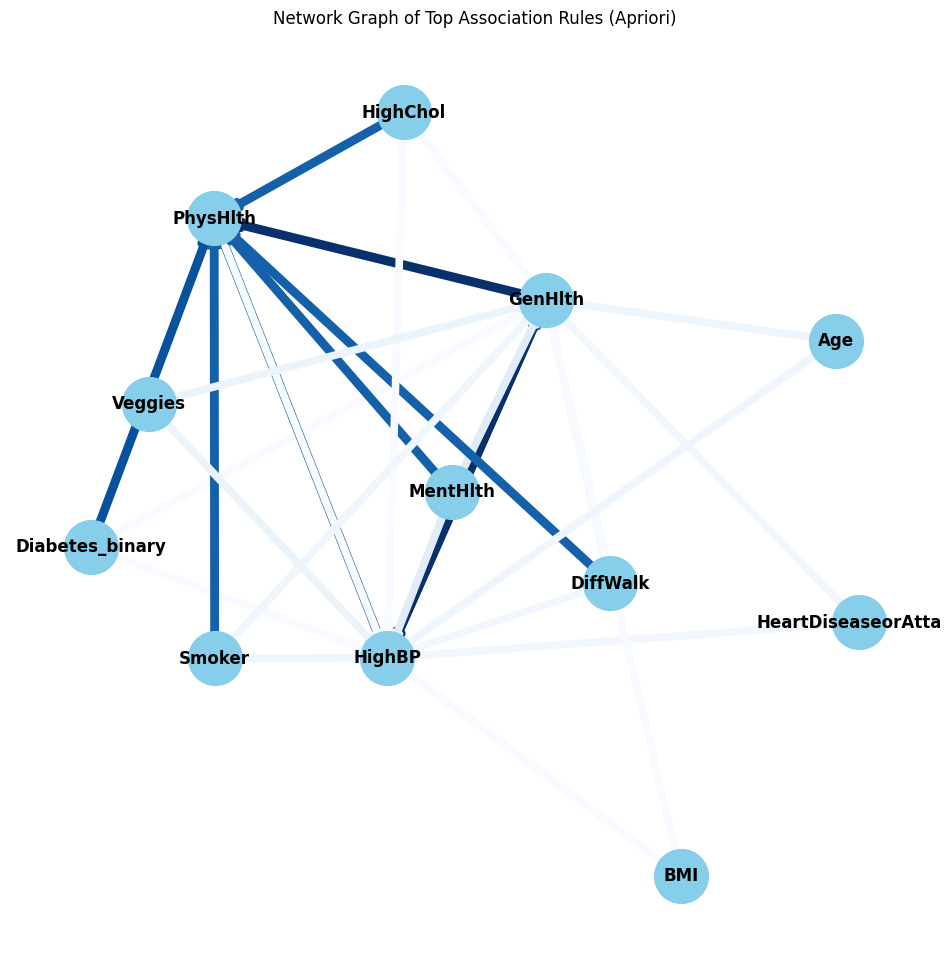

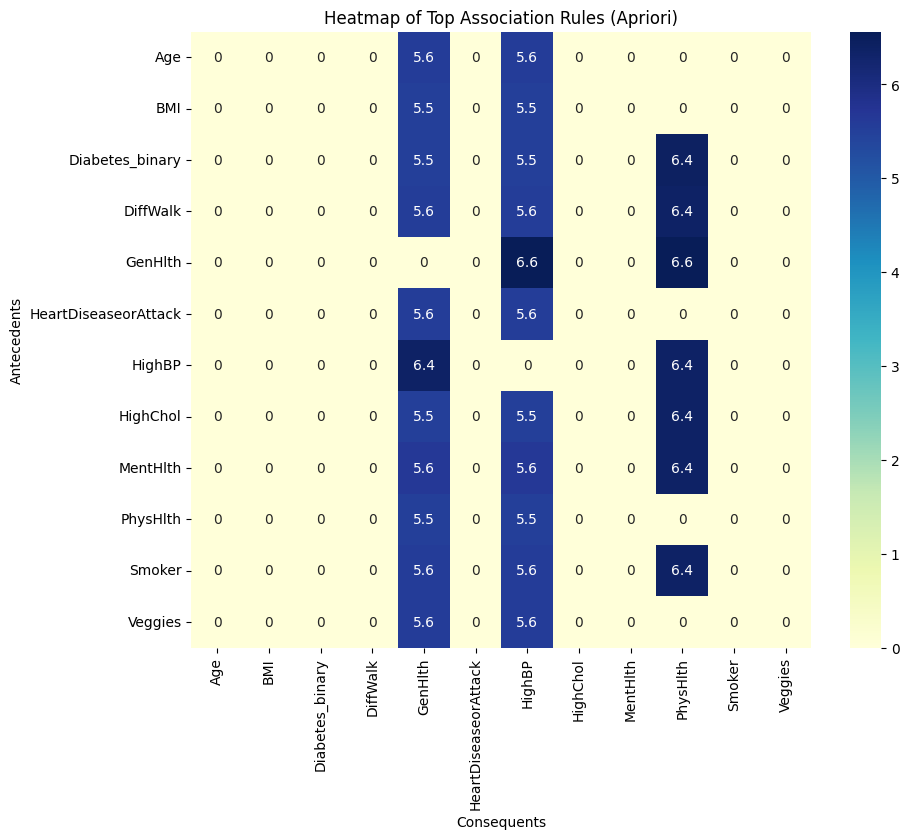

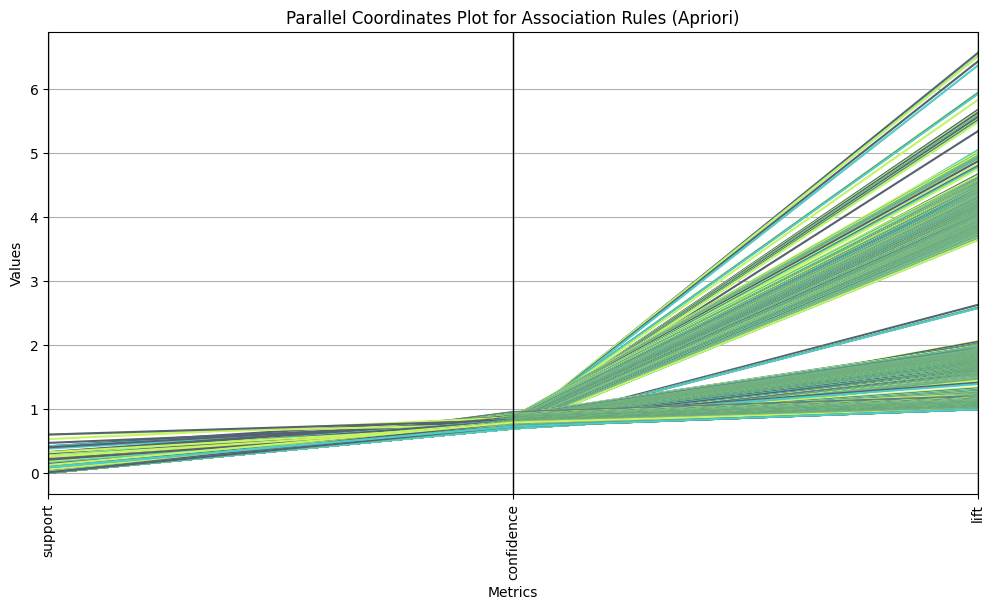

In [11]:
threshold = 0.5  # Define an appropriate threshold based on domain knowledge
health_binarized = health_processed.applymap(lambda x: 1 if x > threshold else 0)
transactions_health = health_binarized.apply(lambda row: row.index[row == 1].tolist(), axis=1).tolist()

# Optionally, inspect a few transactions:
print("Sample transactions:")
print(transactions_health[:5])

te = TransactionEncoder()
te_ary = te.fit(transactions_health).transform(transactions_health)
health_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Verify that health_encoded is created
print("One-hot encoded data:")
print(health_encoded.head())

# --- 1. Apply Apriori to the Health Dataset ---
# Assuming 'health_encoded' is your one-hot encoded DataFrame
frequent_itemsets_health = apriori(health_encoded, min_support=0.01, use_colnames=True)
print("Frequent Itemsets (Apriori):")
print(frequent_itemsets_health.head(10))

# --- 2. Generate Association Rules from Frequent Itemsets ---
# Your version of association_rules requires the number of frequent itemsets as a second parameter.
num_itemsets = len(frequent_itemsets_health)
rules_health = association_rules(frequent_itemsets_health, num_itemsets, metric="confidence", min_threshold=0.6)

# --- 3. Filter and Sort the Rules ---
# For example, we filter for rules with a lift > 1 and confidence > 0.7
filtered_rules_health = rules_health[(rules_health['lift'] > 1) & (rules_health['confidence'] > 0.7)]
sorted_rules_health = filtered_rules_health.sort_values(by='lift', ascending=False)

print("\nTop 10 Association Rules (Apriori) for Health Dataset:")
print(sorted_rules_health.head(10))

# ---------- 1. Scatter Plot: Support vs Confidence ----------
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sorted_rules_health, x='support', y='confidence', 
                size='lift', sizes=(20, 200), legend=False)
plt.title('Association Rules (Apriori): Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)
plt.show()

# ---------- 2. Network Graph of Top 20 Association Rules ----------
def draw_network_graph(rules, top_n=20):
    """
    Draws a directed network graph for the top_n association rules.
    Nodes represent items; edges (with thickness based on lift) represent the rule.
    """
    G = nx.DiGraph()
    # Select top_n rules by lift
    top_rules = rules.nlargest(top_n, 'lift')
    for _, row in top_rules.iterrows():
        # For each combination of antecedent and consequent, add an edge
        for ant in row['antecedents']:
            for cons in row['consequents']:
                G.add_edge(ant, cons, weight=row['lift'])
    pos = nx.spring_layout(G, k=1.5, iterations=50)
    plt.figure(figsize=(12, 12))
    edges = G.edges(data=True)
    edge_weights = [edata['weight'] for _, _, edata in edges]
    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_weights, edge_cmap=plt.cm.Blues)
    plt.title('Network Graph of Top Association Rules (Apriori)')
    plt.axis('off')
    plt.show()

draw_network_graph(sorted_rules_health, top_n=20)

# ---------- 3. Heatmap of Top 20 Association Rules ----------
# Extract top 20 rules by lift
top_rules = sorted_rules_health.nlargest(20, 'lift')
# Collect all unique items from both antecedents and consequents
items = sorted(set(item for rule in top_rules['antecedents'] for item in rule) | 
               set(item for rule in top_rules['consequents'] for item in rule))
# Create a matrix where each cell represents the lift value for an antecedent-consequent pair
matrix = np.zeros((len(items), len(items)))
item_index = {item: idx for idx, item in enumerate(items)}

for _, rule in top_rules.iterrows():
    for ant in rule['antecedents']:
        for cons in rule['consequents']:
            matrix[item_index[ant], item_index[cons]] = rule['lift']

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, xticklabels=items, yticklabels=items, cmap='YlGnBu')
plt.title('Heatmap of Top Association Rules (Apriori)')
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.show()

# ---------- 4. Parallel Coordinates Plot for Rule Metrics ----------
# Prepare data: convert antecedents and consequents to comma-separated strings
parallel_data = sorted_rules_health[['antecedents','consequents','support','confidence','lift']].copy()
parallel_data['antecedents'] = parallel_data['antecedents'].apply(lambda x: ', '.join(list(x)))
parallel_data['consequents'] = parallel_data['consequents'].apply(lambda x: ', '.join(list(x)))
parallel_data['rule'] = parallel_data['antecedents'] + ' -> ' + parallel_data['consequents']

plt.figure(figsize=(12, 6))
parallel_coordinates(parallel_data, 'rule', cols=['support','confidence','lift'], 
                     color=('#556270', '#4ECDC4', '#C7F464'))
plt.title('Parallel Coordinates Plot for Association Rules (Apriori)')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(rotation=90)
plt.legend([], frameon=False)
plt.show()


<h4>FP-Growth on Pima Dataset</h4>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-12-10588ed0b69d>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pima_binarized = pima_processed.applymap(lambda x: 1 if x > threshold else 0)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



--- FP-Growth on Pima Dataset ---
                                           antecedents  \
253     (BloodPressure, Outcome, Insulin, Pregnancies)   
345         (BloodPressure, BMI, Insulin, Pregnancies)   
251     (Glucose, BloodPressure, Insulin, Pregnancies)   
269       (Age, BloodPressure, Insulin, SkinThickness)   
346                 (Age, BloodPressure, BMI, Insulin)   
136  (Age, BloodPressure, SkinThickness, DiabetesPe...   
254             (Glucose, BloodPressure, Insulin, Age)   
338       (Age, BloodPressure, Insulin, SkinThickness)   
266  (BloodPressure, Insulin, SkinThickness, Pregna...   
47                  (Glucose, BMI, SkinThickness, Age)   

                consequents  antecedent support  consequent support   support  \
253          (Glucose, Age)            0.019531            0.113281  0.014323   
345          (Age, Outcome)            0.011719            0.140625  0.010417   
251          (Age, Outcome)            0.016927            0.140625  0.014323   
26

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


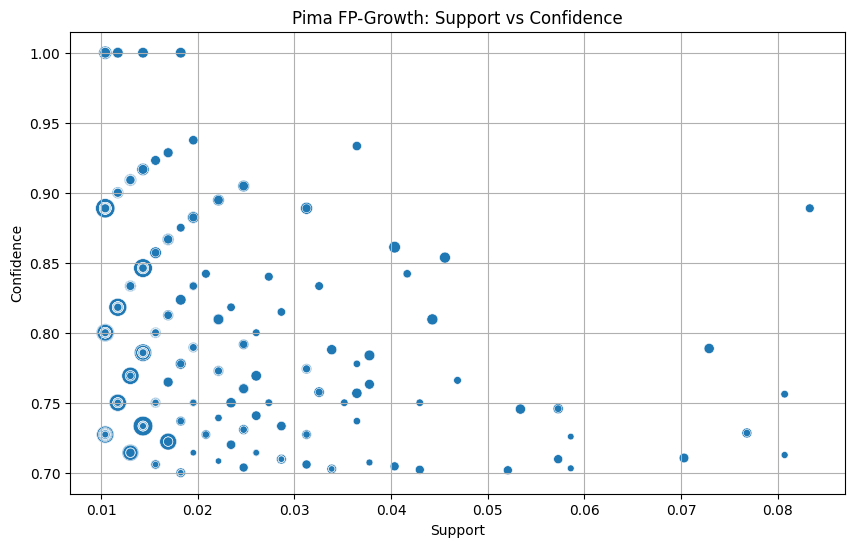

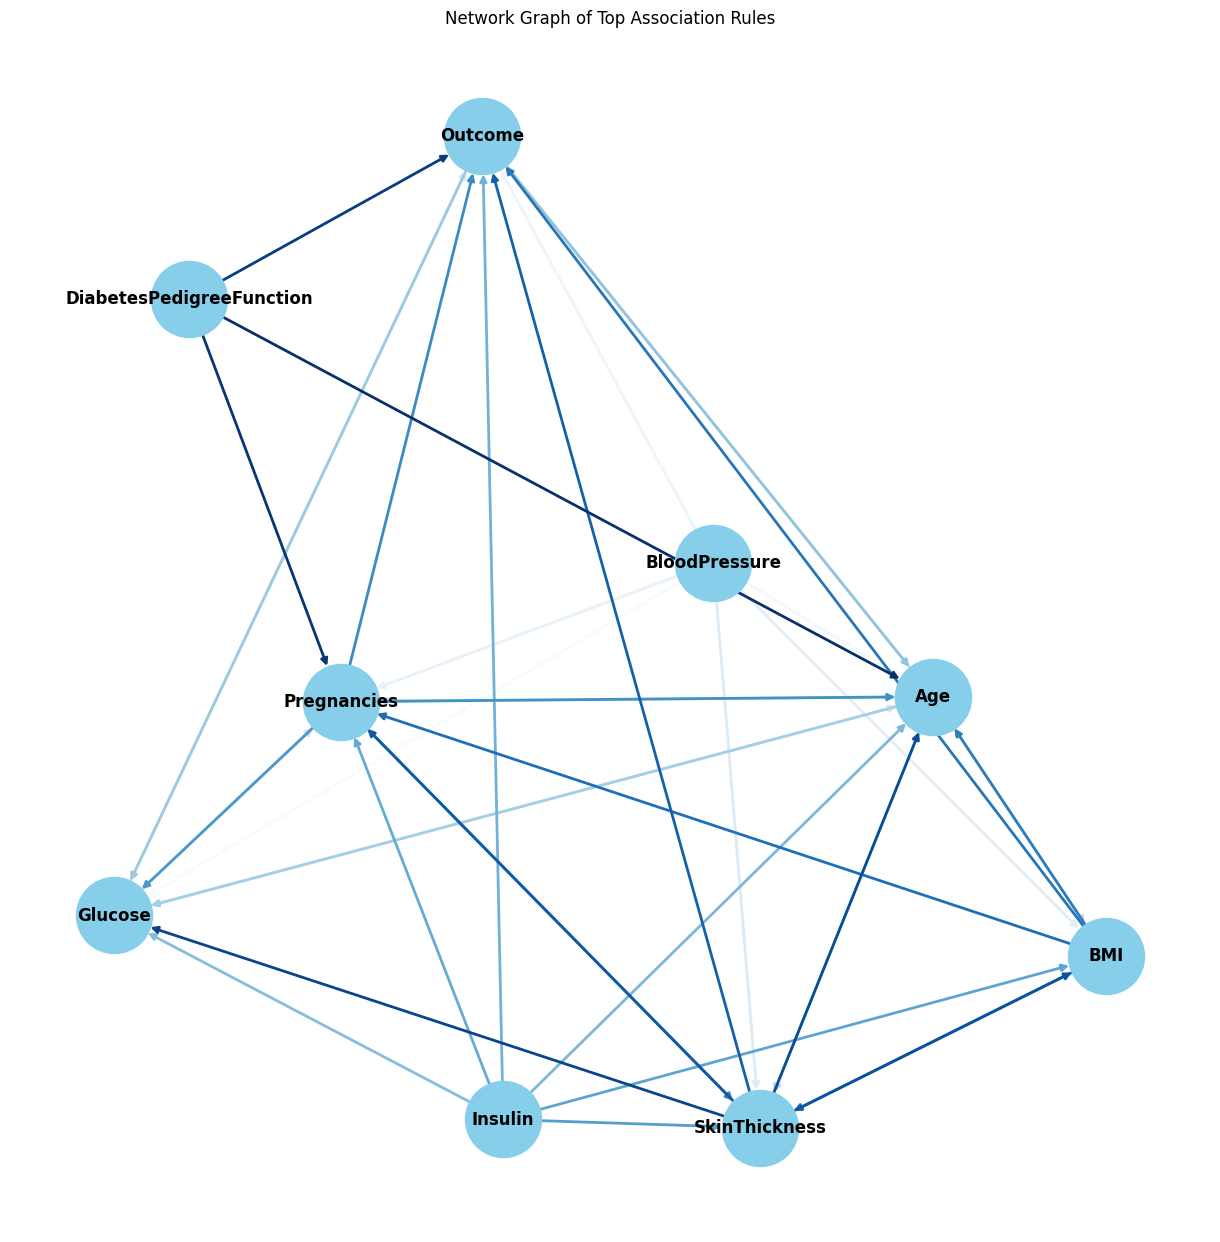

In [12]:
# --- 6.3 FP-Growth on Pima Dataset ---
print("\n--- FP-Growth on Pima Dataset ---")
# Binarize the data (example threshold: 0.5)
threshold = 0.5
pima_binarized = pima_processed.applymap(lambda x: 1 if x > threshold else 0)
frequent_itemsets_pima_fp = fpgrowth(pima_binarized, min_support=0.01, use_colnames=True)
num_itemsets = len(frequent_itemsets_pima_fp)
rules_pima_fp = association_rules(frequent_itemsets_pima_fp, num_itemsets, metric="confidence", min_threshold=0.6)
filtered_rules_pima = rules_pima_fp[(rules_pima_fp['lift'] > 1.2) & (rules_pima_fp['confidence'] > 0.7)]
sorted_rules_pima = filtered_rules_pima.sort_values(by='lift', ascending=False)
print(sorted_rules_pima.head(10))

# Visualization for FP-Growth results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='support', y='confidence', size='lift', data=sorted_rules_pima, legend=False, sizes=(20, 200))
plt.title('Pima FP-Growth: Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)
plt.show()

def draw_graph(rules, top_n):
    G = nx.DiGraph()
    top_rules = rules.head(top_n)
    for _, rule in top_rules.iterrows():
        for antecedent in rule['antecedents']:
            for consequent in rule['consequents']:
                G.add_edge(antecedent, consequent, weight=rule['lift'])
    pos = nx.spring_layout(G, k=1.5, iterations=50)
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', 
            font_size=12, font_weight='bold', edge_color=range(len(G.edges)),
            edge_cmap=plt.cm.Blues, width=2.0)
    plt.title('Network Graph of Top Association Rules')
    plt.show()

draw_graph(sorted_rules_pima, top_n=20)

<h4>FP-Growth on Health Dataset</h4>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Frequent Itemsets from FP-Growth:
    support        itemsets
0  0.794026       (Veggies)
1  0.466360        (Smoker)
2  0.457737        (HighBP)
3  0.445123      (HighChol)
4  0.219041           (BMI)
5  0.192271       (GenHlth)
6  0.187618      (DiffWalk)
7  0.175522      (PhysHlth)
8  0.140698      (MentHlth)
9  0.731889  (PhysActivity)

Total rules generated (FP-Growth): 14425

Top 10 Association Rules from FP-Growth:
                                             antecedents          consequents  \
5609      (Diabetes_binary, GenHlth, MentHlth, DiffWalk)   (HighBP, PhysHlth)   
5636     (Diabetes_binary, HighChol, MentHlth, DiffWalk)  (GenHlth, PhysHlth)   
5606       (Diabetes_binary, MentHlth, DiffWalk, HighBP)  (GenHlth, PhysHlth)   
5594               (Diabetes_binary, MentHlth, DiffWalk)  (GenHlth, PhysHlth)   
5130      (HighBP, HighChol, MentHlth, DiffWalk, Smoker)  (GenHlth, PhysHlth)   
12332  (HighChol, DiffWalk, HeartDiseaseorAttack, Smo...    (GenHlth, HighBP)   
12194  

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


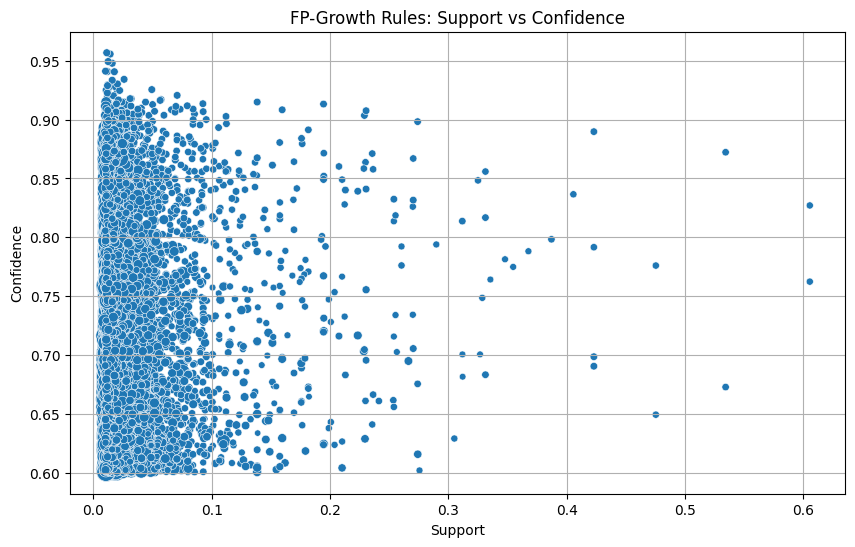

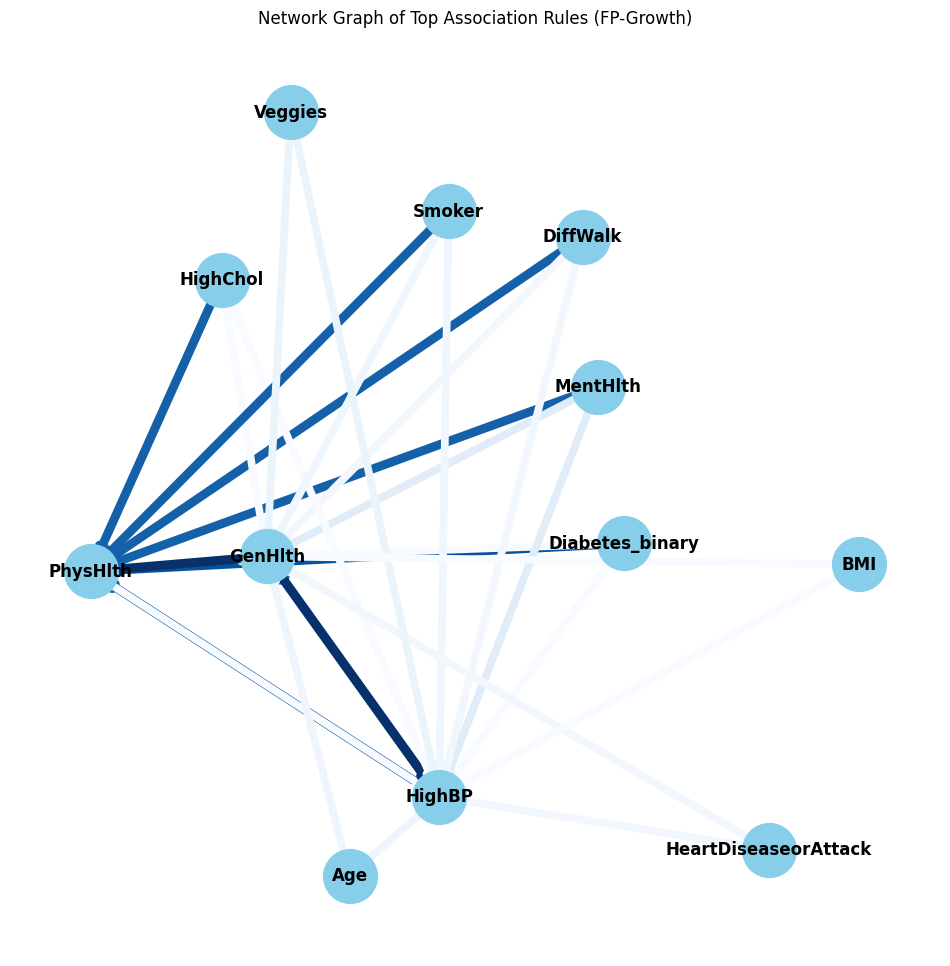

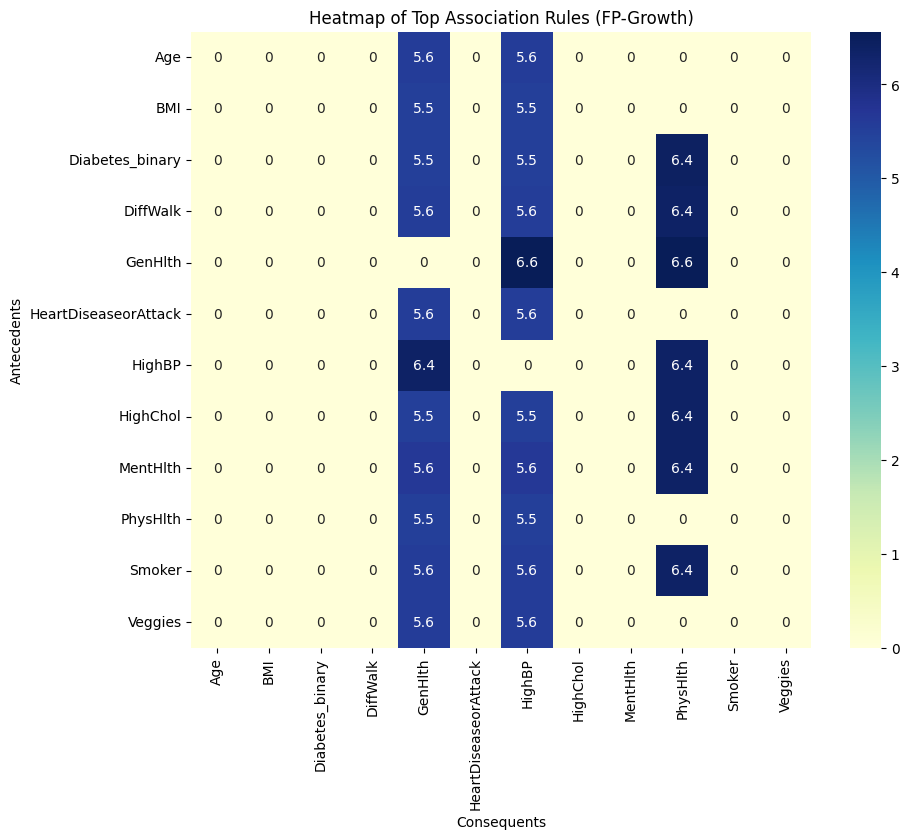

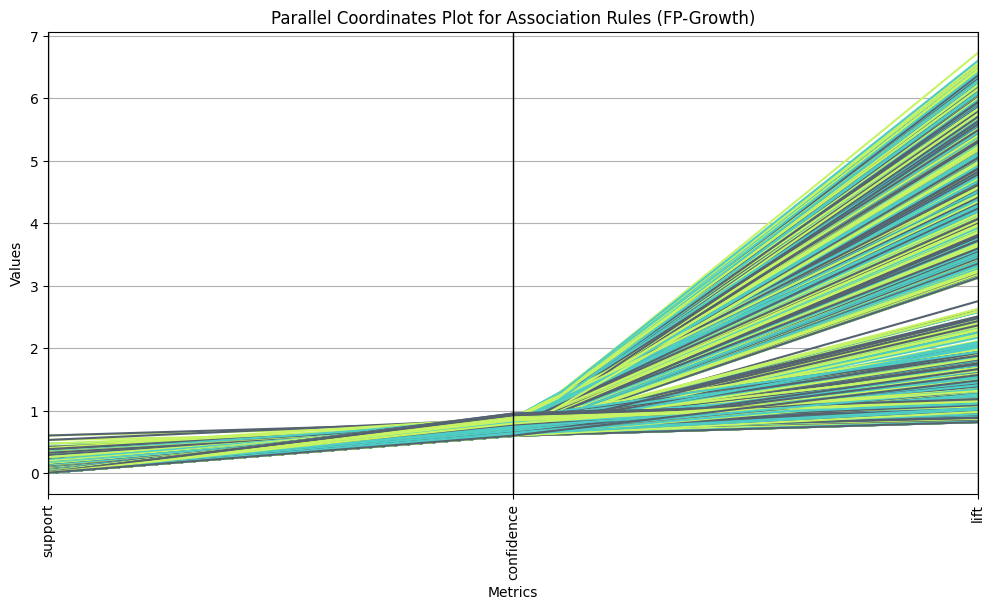

In [13]:
# ------------------------------
# 1. Apply FP-Growth to the Health Dataset
# ------------------------------
frequent_itemsets_health_fp = fpgrowth(health_encoded, min_support=0.01, use_colnames=True)
print("Frequent Itemsets from FP-Growth:")
print(frequent_itemsets_health_fp.head(10))

# ------------------------------
# 2. Generate Association Rules from FP-Growth Frequent Itemsets
# ------------------------------
num_itemsets = len(frequent_itemsets_health_fp)
rules_health_fp = association_rules(frequent_itemsets_health_fp, num_itemsets, metric="confidence", min_threshold=0.6)
print("\nTotal rules generated (FP-Growth):", len(rules_health_fp))

# ------------------------------
# 3. Filter and Sort the Rules
# ------------------------------
# Filter for rules with lift > 1 and confidence > 0.7 (adjust thresholds as needed)
filtered_rules_health_fp = rules_health_fp[(rules_health_fp['lift'] > 1) & (rules_health_fp['confidence'] > 0.7)]
sorted_rules_health_fp = filtered_rules_health_fp.sort_values(by='lift', ascending=False)
print("\nTop 10 Association Rules from FP-Growth:")
print(sorted_rules_health_fp.head(10))

# ------------------------------
# 4. Visualization of FP-Growth Association Rules
# ------------------------------

# --- 4.1 Scatter Plot: Support vs Confidence ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rules_health_fp, x='support', y='confidence', 
                size='lift', sizes=(20, 200), legend=False)
plt.title('FP-Growth Rules: Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)
plt.show()

# --- 4.2 Network Graph of Top 20 Association Rules ---
def draw_network_graph(rules, top_n=20):
    """
    Draws a directed network graph for the top_n association rules.
    Nodes represent items; edges (with thickness based on lift) represent the association.
    """
    G = nx.DiGraph()
    # Select top_n rules by lift
    top_rules = rules.nlargest(top_n, 'lift')
    for _, row in top_rules.iterrows():
        # For each rule, add an edge from each antecedent to each consequent.
        for ant in row['antecedents']:
            for cons in row['consequents']:
                G.add_edge(ant, cons, weight=row['lift'])
    pos = nx.spring_layout(G, k=1.5, iterations=50)
    plt.figure(figsize=(12, 12))
    edges = G.edges(data=True)
    edge_weights = [edata['weight'] for _, _, edata in edges]
    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_weights, edge_cmap=plt.cm.Blues)
    plt.title('Network Graph of Top Association Rules (FP-Growth)')
    plt.axis('off')
    plt.show()

draw_network_graph(sorted_rules_health_fp, top_n=20)

# --- 4.3 Heatmap of Top 20 Association Rules ---
top_rules = sorted_rules_health_fp.nlargest(20, 'lift')
# Collect all unique items from antecedents and consequents
items = sorted(set(item for rule in top_rules['antecedents'] for item in rule) | 
               set(item for rule in top_rules['consequents'] for item in rule))
matrix = np.zeros((len(items), len(items)))
item_index = {item: idx for idx, item in enumerate(items)}

for _, rule in top_rules.iterrows():
    for ant in rule['antecedents']:
        for cons in rule['consequents']:
            matrix[item_index[ant], item_index[cons]] = rule['lift']

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, xticklabels=items, yticklabels=items, cmap='YlGnBu')
plt.title('Heatmap of Top Association Rules (FP-Growth)')
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.show()

# --- 4.4 Parallel Coordinates Plot for Rule Metrics ---
parallel_data = rules_health_fp[['antecedents','consequents','support','confidence','lift']].copy()
parallel_data['antecedents'] = parallel_data['antecedents'].apply(lambda x: ', '.join(list(x)))
parallel_data['consequents'] = parallel_data['consequents'].apply(lambda x: ', '.join(list(x)))
parallel_data['rule'] = parallel_data['antecedents'] + ' -> ' + parallel_data['consequents']

plt.figure(figsize=(12, 6))
parallel_coordinates(parallel_data, 'rule', cols=['support','confidence','lift'], 
                     color=('#556270', '#4ECDC4', '#C7F464'))
plt.title('Parallel Coordinates Plot for Association Rules (FP-Growth)')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(rotation=90)
plt.legend([], frameon=False)
plt.show()


<h4>ECLAT Algorithm on the Pima Dataset</h4>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated an

One-hot encoded Pima dataset shape: (768, 23)
   Pregnancies_(-0.548, 0.343]  Pregnancies_(-1.1429999999999998, -0.548]  \
0                        False                                      False   
1                        False                                       True   
2                        False                                      False   
3                        False                                       True   
4                        False                                       True   

   Pregnancies_(0.343, 3.907]  Glucose_(-0.497, 0.285]  \
0                        True                    False   
1                       False                    False   
2                        True                    False   
3                       False                    False   
4                       False                    False   

   Glucose_(-3.7849999999999997, -0.497]  Glucose_(0.285, 2.444]  \
0                                  False                    True   
1     

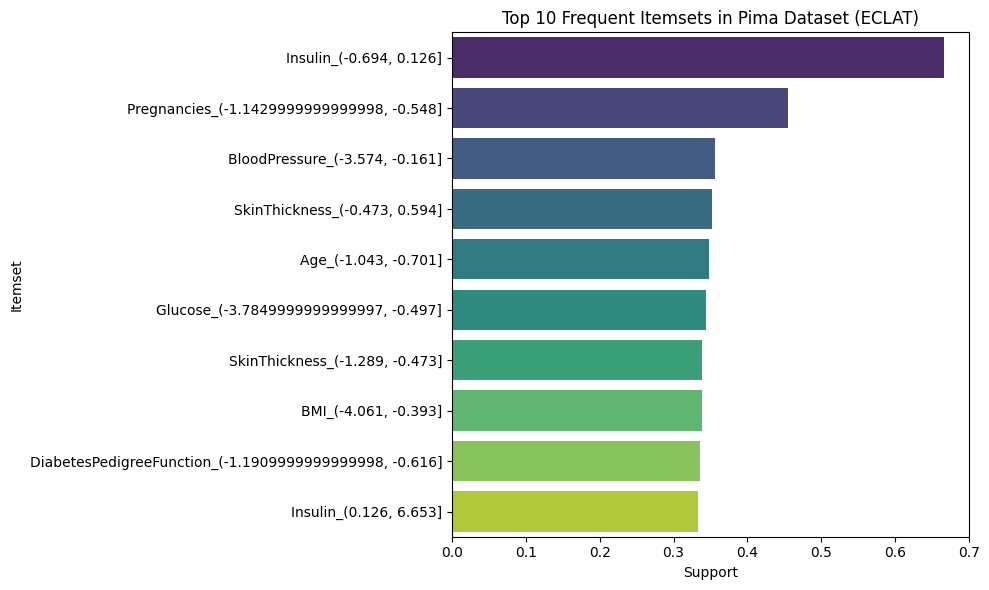

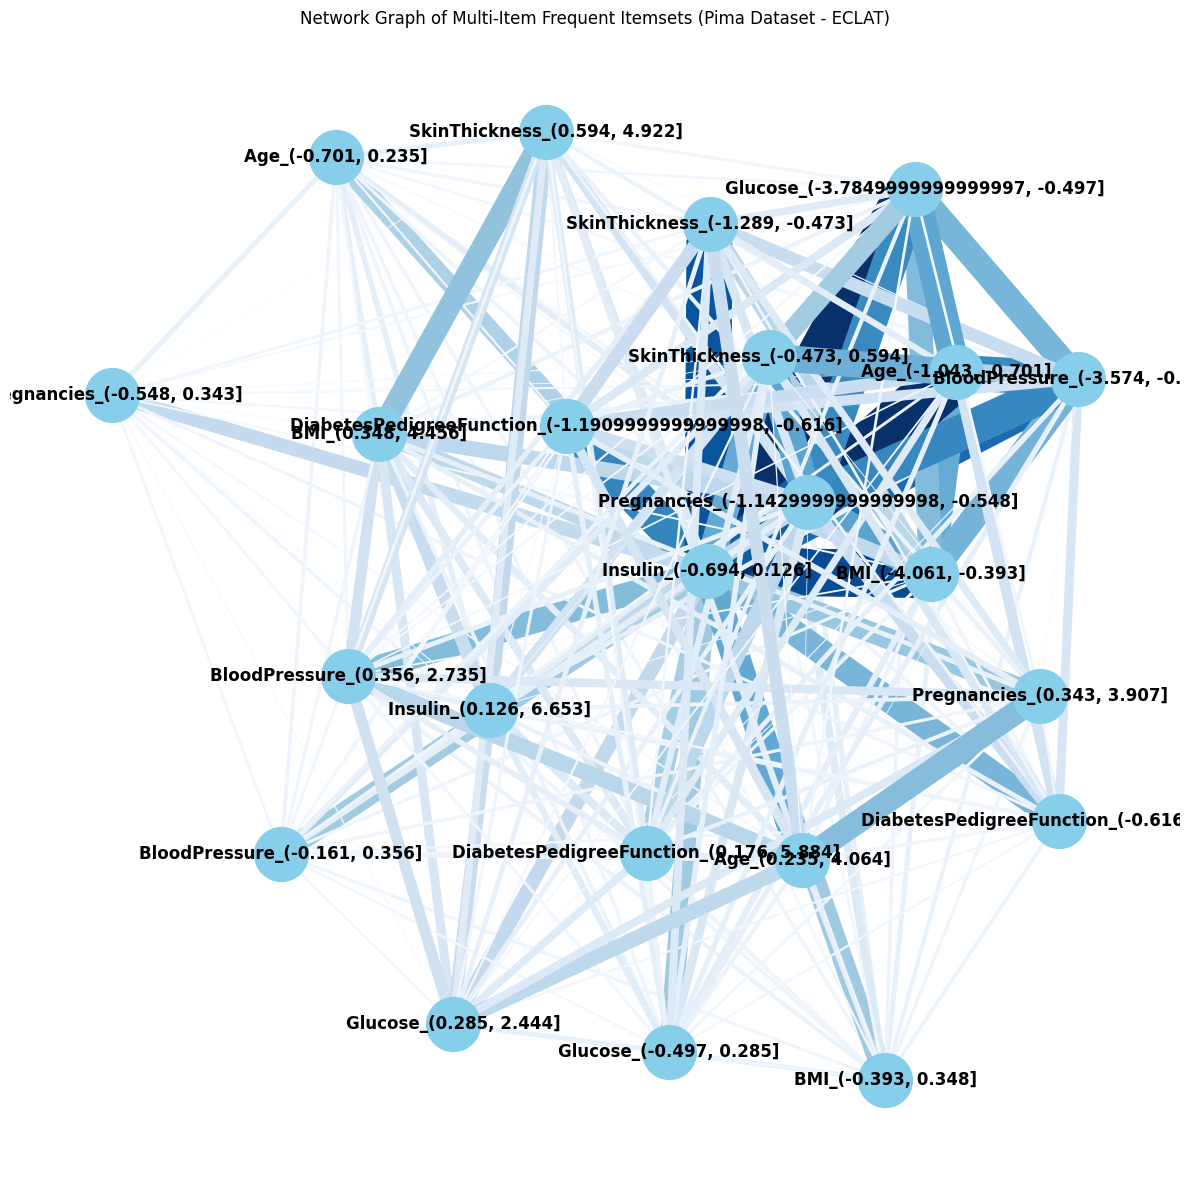

In [14]:
# Convert numeric features into categorical bins.
# This function should convert each numeric column into a categorical variable.
def convert_to_categorical(df, bins=3):
    for col in df.select_dtypes(include=[np.number]).columns:
        # Use pd.qcut to bin the data; adjust number of bins as needed.
        df[col] = pd.qcut(df[col], q=bins, duplicates='drop').astype(str)
    return df

# Create a copy of the Pima dataset and convert numeric features to categorical.
pima_cat = convert_to_categorical(pima_processed.copy(), bins=3)

# Drop the target variable so that we only mine on the features.
pima_cat_features = pima_cat.drop(columns=['Outcome'])

# One-hot encode the categorical data.
# You can use pd.get_dummies here.
pima_encoded = pd.get_dummies(pima_cat_features)

print("One-hot encoded Pima dataset shape:", pima_encoded.shape)
print(pima_encoded.head())

# ----------------------------------------------------------------
# STEP 1: Apply the Modified ECLAT Algorithm on the Pima Dataset
# ----------------------------------------------------------------
# Make sure your modified ECLAT function is defined.
# (Below is an example definition of eclat_modified if you haven't defined it already.)

def eclat_modified(df, min_support=0.01):
    """
    Performs the ECLAT algorithm on a one-hot encoded DataFrame.
    Returns a dictionary mapping frozensets (frequent itemsets) to their support.
    """
    n_transactions = len(df)
    # Build a dictionary mapping each item to the set of transaction indices where it appears.
    tids_dict = {}
    for item in df.columns:
        tids = set(df.index[df[item] == 1])
        support = len(tids) / n_transactions
        if support >= min_support:
            tids_dict[item] = tids
    # Sort items for a consistent order.
    items = sorted(tids_dict.keys())
    
    def recursive_eclat(prefix, items, tids_dict):
        freq_itemsets = {}
        for i, item in enumerate(items):
            new_itemset = prefix | {item}
            new_tids = tids_dict[item]
            support = len(new_tids) / n_transactions
            if support >= min_support:
                freq_itemsets[frozenset(new_itemset)] = support
                new_items = []
                new_tids_dict = {}
                for j in range(i + 1, len(items)):
                    other = items[j]
                    intersection = new_tids & tids_dict[other]
                    if len(intersection) / n_transactions >= min_support:
                        new_items.append(other)
                        new_tids_dict[other] = intersection
                freq_itemsets.update(recursive_eclat(new_itemset, new_items, new_tids_dict))
        return freq_itemsets

    return recursive_eclat(set(), items, tids_dict)

# Apply ECLAT on the one-hot encoded Pima data.
# Adjust the min_support value based on your dataset size and desired granularity.
frequent_itemsets_pima = eclat_modified(pima_encoded, min_support=0.05)
results_pima = [{'itemsets': list(itemset), 'support': support} 
                for itemset, support in frequent_itemsets_pima.items()]
pima_results_df = pd.DataFrame(results_pima)

print("\nFrequent Itemsets from Pima (ECLAT):")
print(pima_results_df.sort_values(by='support', ascending=False).head(10))

# ----------------------------------------------------------------
# STEP 2: Visualize the Frequent Itemsets from Pima Dataset
# ----------------------------------------------------------------

# 2.1 Bar Chart: Top Frequent Itemsets
pima_results_df['itemset_str'] = pima_results_df['itemsets'].apply(lambda x: ', '.join(sorted(x)))
top_itemsets_pima = pima_results_df.sort_values(by='support', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_itemsets_pima, x='support', y='itemset_str', palette='viridis')
plt.title("Top 10 Frequent Itemsets in Pima Dataset (ECLAT)")
plt.xlabel("Support")
plt.ylabel("Itemset")
plt.tight_layout()
plt.show()

# 2.2 Network Graph: Visualizing Multi-Item Frequent Itemsets
# Build a network graph where nodes are items and edges represent co-occurrence in multi-item sets.
G = nx.Graph()

# Add edges only for itemsets containing more than one item.
for idx, row in pima_results_df.iterrows():
    items = row['itemsets']
    supp = row['support']
    if len(items) > 1:
        for i in range(len(items)):
            for j in range(i + 1, len(items)):
                # If an edge already exists, you might want to accumulate weights.
                if G.has_edge(items[i], items[j]):
                    G[items[i]][items[j]]['weight'] += supp
                else:
                    G.add_edge(items[i], items[j], weight=supp)

plt.figure(figsize=(12, 12))
if G.number_of_nodes() > 0:
    pos = nx.spring_layout(G, k=1.5, iterations=50)
    edges = G.edges(data=True)
    # Scale edge width for better visibility.
    edge_weights = [edata['weight'] * 10 for _, _, edata in edges]
    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_weights, edge_cmap=plt.cm.Blues)
    plt.title("Network Graph of Multi-Item Frequent Itemsets (Pima Dataset - ECLAT)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No multi-item frequent itemsets found for network visualization.")


<h4>ECLAT on Health Dataset</h4>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Raw results:
[{'itemsets': ['Age'], 'support': 0.3649427006332413}, {'itemsets': ['Age', 'BMI'], 'support': 0.0651401078475777}, {'itemsets': ['Age', 'BMI', 'Diabetes_binary'], 'support': 0.027209721664373552}, {'itemsets': ['Age', 'BMI', 'DiffWalk', 'Diabetes_binary'], 'support': 0.014173154328003623}, {'itemsets': ['Age', 'BMI', 'Diabetes_binary', 'DiffWalk', 'Fruits'], 'support': 0.00837057863387371}]
DataFrame columns: Index(['itemsets', 'support'], dtype='object')
DataFrame head:
                                        itemsets   support
0                                          [Age]  0.364943
1                                     [Age, BMI]  0.065140
2                    [Age, BMI, Diabetes_binary]  0.027210
3          [Age, BMI, DiffWalk, Diabetes_binary]  0.014173
4  [Age, BMI, Diabetes_binary, DiffWalk, Fruits]  0.008371
                                                itemsets   support
14763                                          [Veggies]  0.794026
14707                 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


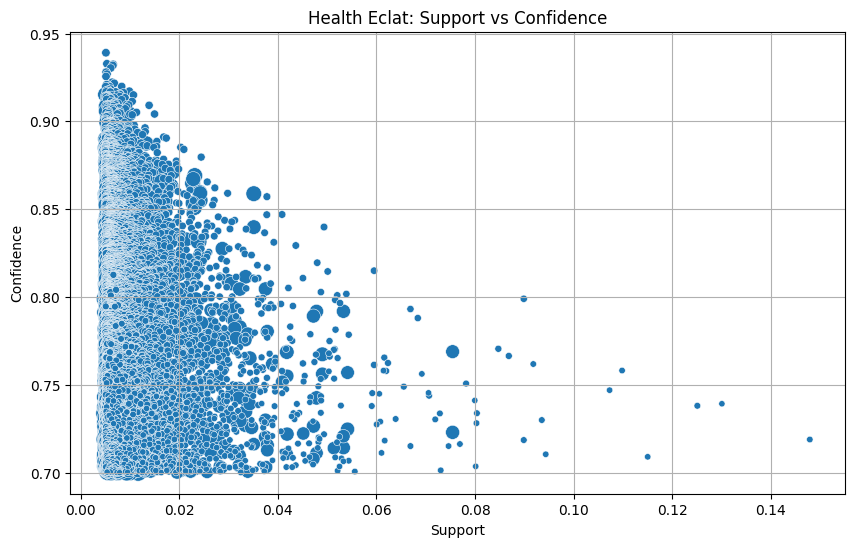

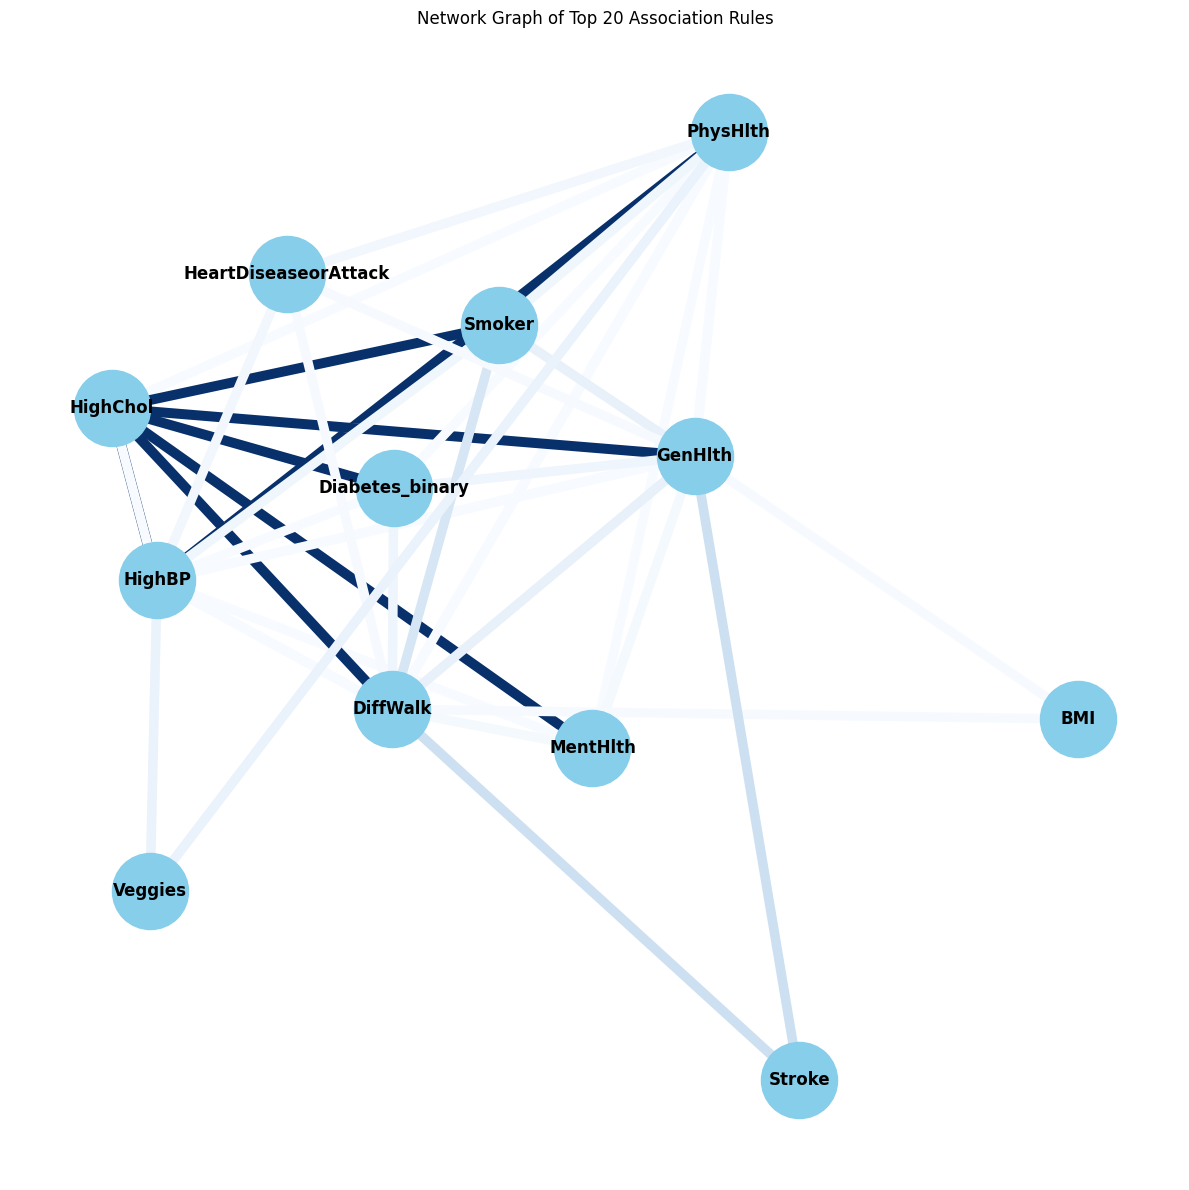

In [15]:
# --- 6.4 ECLAT on Health Dataset ---
# First, prepare one-hot encoded data from the health dataset
def eclat_modified(df, min_support=0.01):
    """
    Performs the ECLAT algorithm on a one-hot encoded DataFrame.
    Returns a dictionary mapping frozensets (frequent itemsets) to their support.
    
    Parameters:
      df : pandas.DataFrame
         One-hot encoded DataFrame where each column represents an item and rows are transactions.
      min_support : float
         Minimum support threshold (e.g., 0.01 for 1%).
    """
    n_transactions = len(df)
    
    # Build a dictionary mapping each item to the set of transaction indices where it's present.
    tids_dict = {}
    for item in df.columns:
        # Consider an item present if its value is 1 (or True)
        tids = set(df.index[df[item] == 1])
        support = len(tids) / n_transactions
        if support >= min_support:
            tids_dict[item] = tids
    
    # Sort items to enforce a consistent order
    items = sorted(tids_dict.keys())

    def recursive_eclat(prefix, items, tids_dict):
        """
        Recursive helper function that builds frequent itemsets.
        
        prefix: a set representing the current itemset.
        items: a list of items (strings) to try adding to the prefix.
        tids_dict: a dictionary mapping each item (in items) to its TID set.
        """
        freq_itemsets = {}
        for i, item in enumerate(items):
            new_itemset = prefix | {item}
            new_tids = tids_dict[item]
            support = len(new_tids) / n_transactions
            if support >= min_support:
                freq_itemsets[frozenset(new_itemset)] = support
                # Prepare for the recursive step: consider only items that come after the current one.
                new_items = []
                new_tids_dict = {}
                for j in range(i + 1, len(items)):
                    other = items[j]
                    # Intersection of transaction IDs for the new itemset and the candidate item.
                    intersection = new_tids & tids_dict[other]
                    if len(intersection) / n_transactions >= min_support:
                        new_items.append(other)
                        new_tids_dict[other] = intersection
                # Recursively build larger itemsets
                freq_itemsets.update(recursive_eclat(new_itemset, new_items, new_tids_dict))
        return freq_itemsets

    # Start with an empty prefix and all items.
    return recursive_eclat(set(), items, tids_dict)

frequent_itemsets_eclat = eclat_modified(health_encoded, min_support=0.005)  # Adjust the min_support as needed
results = [{'itemsets': list(itemset), 'support': support} 
           for itemset, support in frequent_itemsets_eclat.items()]
health_results_eclat = pd.DataFrame(results)
# Debug: print the raw results list
print("Raw results:")
print(results[:5])  # Print first 5 entries

# Create the DataFrame and check its columns
health_results_eclat = pd.DataFrame(results)
print("DataFrame columns:", health_results_eclat.columns)
print("DataFrame head:")
print(health_results_eclat.head())

print(health_results_eclat.sort_values(by='support', ascending=False))

# Ensure the itemsets are in frozenset format (required by association_rules)
health_results_eclat['itemsets'] = health_results_eclat['itemsets'].apply(frozenset)

# Compute the number of itemsets
num_itemsets = len(health_results_eclat)

# Generate association rules using the extra 'num_itemsets' parameter.
rules_eclat = association_rules(health_results_eclat, num_itemsets, metric="confidence", min_threshold=0.6)

# ----------------------------
# Filter and sort rules by additional metrics (e.g., lift and confidence)
filtered_rules_eclat = rules_eclat[(rules_eclat['lift'] > 1.5) & (rules_eclat['confidence'] > 0.7)]
filtered_rules_eclat = filtered_rules_eclat.sort_values(by='lift', ascending=False)

# Display the top 10 rules
print("Top 10 Association Rules from ECLAT frequent itemsets:")
print(filtered_rules_eclat.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x='support', y='confidence', size='lift', data=filtered_rules_eclat, legend=False, sizes=(20, 200))
plt.title('Health Eclat: Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)
plt.show()

# ----------------------------
# Visualize the association rules with a network graph
# ----------------------------
def draw_rules_network(rules, top_n=10):
    """
    Draws a network graph for the top_n association rules.
    Each rule is represented as an edge from its antecedent(s) to its consequent(s).
    Edge thickness reflects the rule's lift.
    """
    G = nx.DiGraph()
    
    # Select top rules based on lift
    top_rules = rules.nlargest(top_n, 'lift')
    
    # Add nodes and edges: For each rule, add an edge for every combination of antecedent and consequent.
    for _, rule in top_rules.iterrows():
        for ant in rule['antecedents']:
            for cons in rule['consequents']:
                G.add_edge(ant, cons, weight=rule['lift'])
    
    pos = nx.spring_layout(G, k=1.5, iterations=50)
    
    plt.figure(figsize=(12, 12))
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='skyblue')
    # Draw edges with widths proportional to lift
    edges = G.edges(data=True)
    edge_widths = [edata['weight'] for _, _, edata in edges]
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_widths, edge_cmap=plt.cm.Blues)
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    
    plt.title(f'Network Graph of Top {top_n} Association Rules')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Draw the network graph for the top 20 rules
draw_rules_network(filtered_rules_eclat, top_n=20)

<h4>Combined Approach on Pima Dataset</h4>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



--- Combined Approach on Pima Dataset ---
Frequent itemsets (Apriori):
    support                                     itemsets
0  0.260417                (Pregnancies_(-0.548, 0.343])
1  0.454427  (Pregnancies_(-1.1429999999999998, -0.548])
2  0.285156                 (Pregnancies_(0.343, 3.907])
3  0.329427                    (Glucose_(-0.497, 0.285])
4  0.343750      (Glucose_(-3.7849999999999997, -0.497])
5  0.326823                     (Glucose_(0.285, 2.444])
6  0.319010              (BloodPressure_(-0.161, 0.356])
7  0.355469             (BloodPressure_(-3.574, -0.161])
8  0.325521               (BloodPressure_(0.356, 2.735])
9  0.351562              (SkinThickness_(-0.473, 0.594])

Frequent itemsets (FP-Growth):
    support                                     itemsets
0  0.666667                    (Insulin_(-0.694, 0.126])
1  0.333333    (DiabetesPedigreeFunction_(0.176, 5.884])
2  0.330729                         (Age_(0.235, 4.064])
3  0.328125                        (BMI_(

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


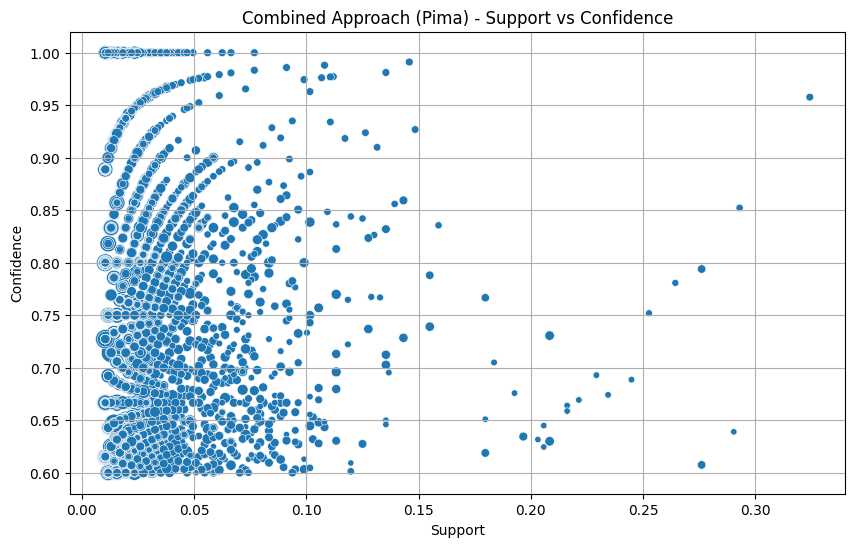

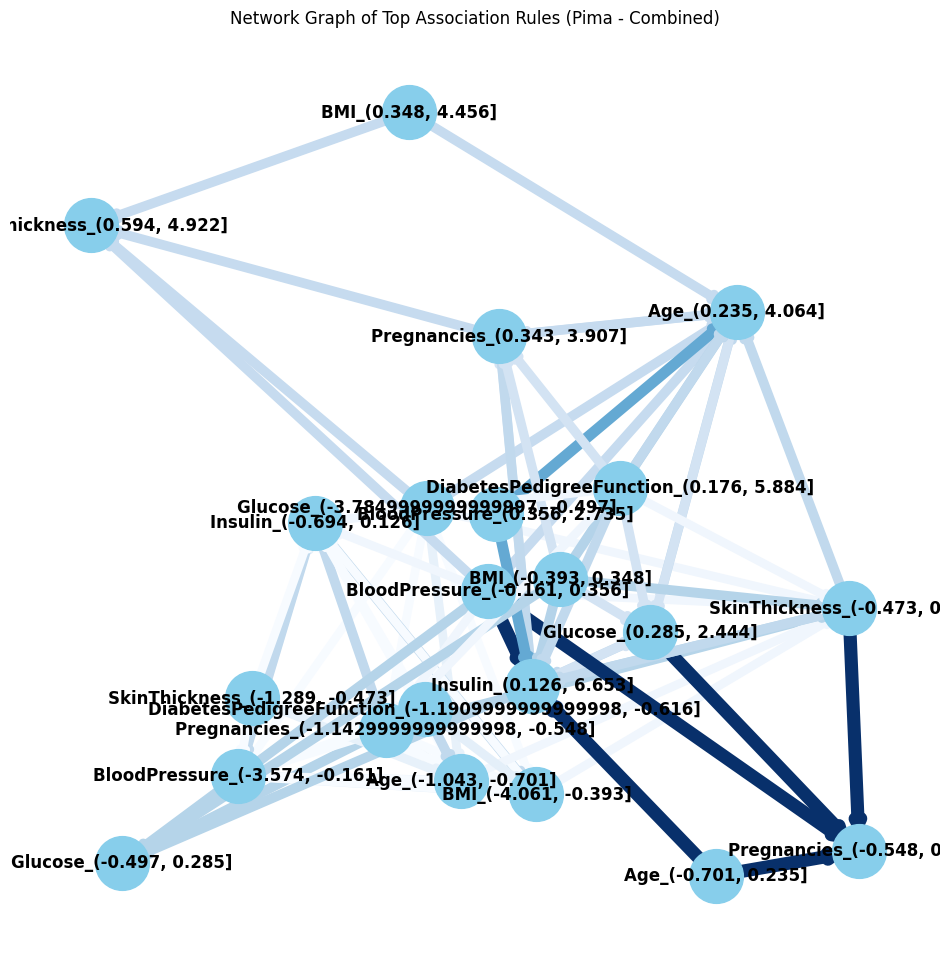

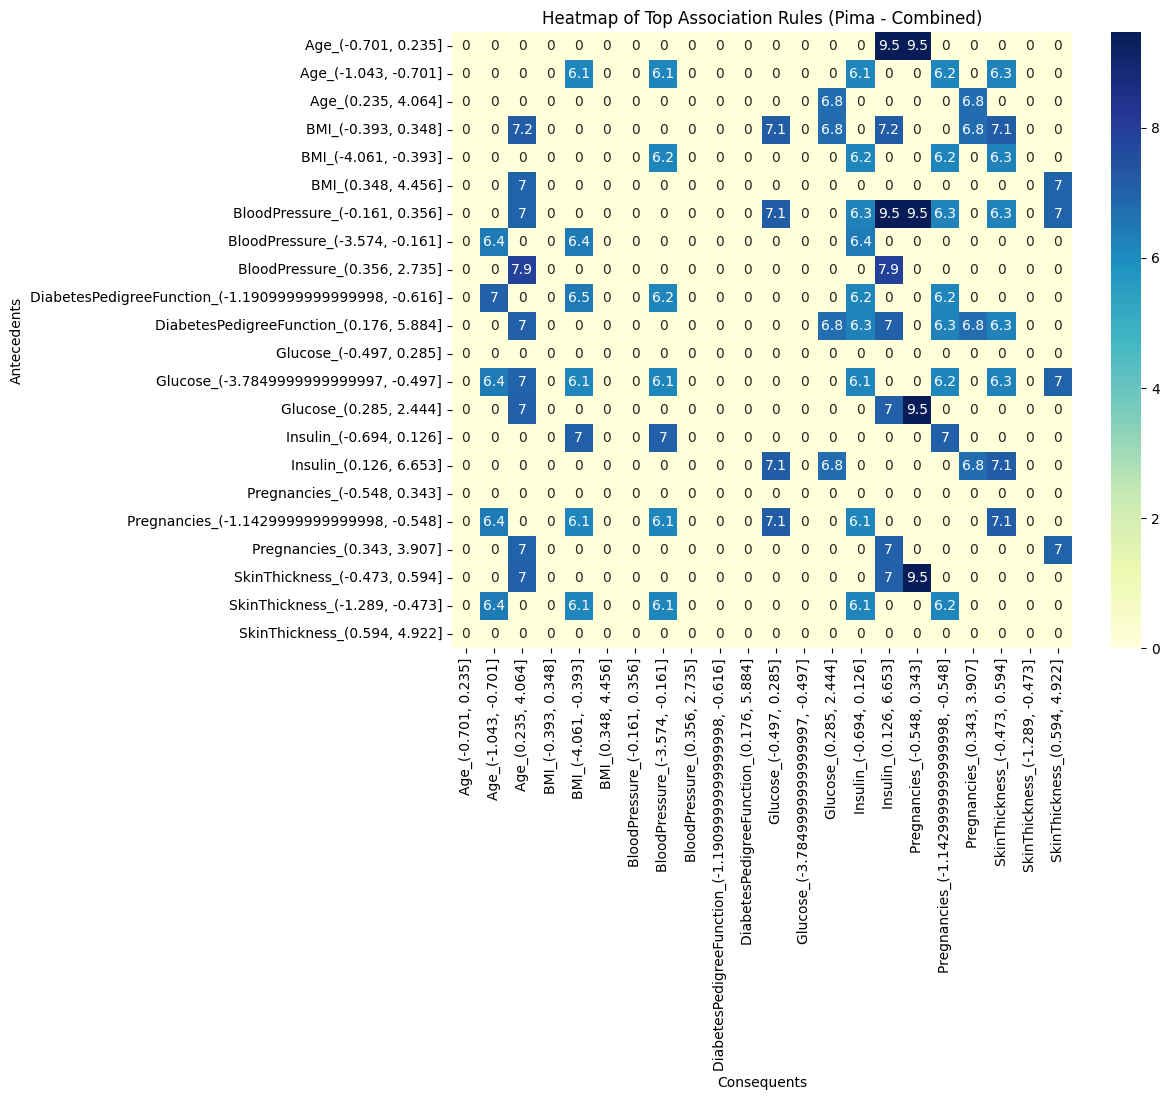

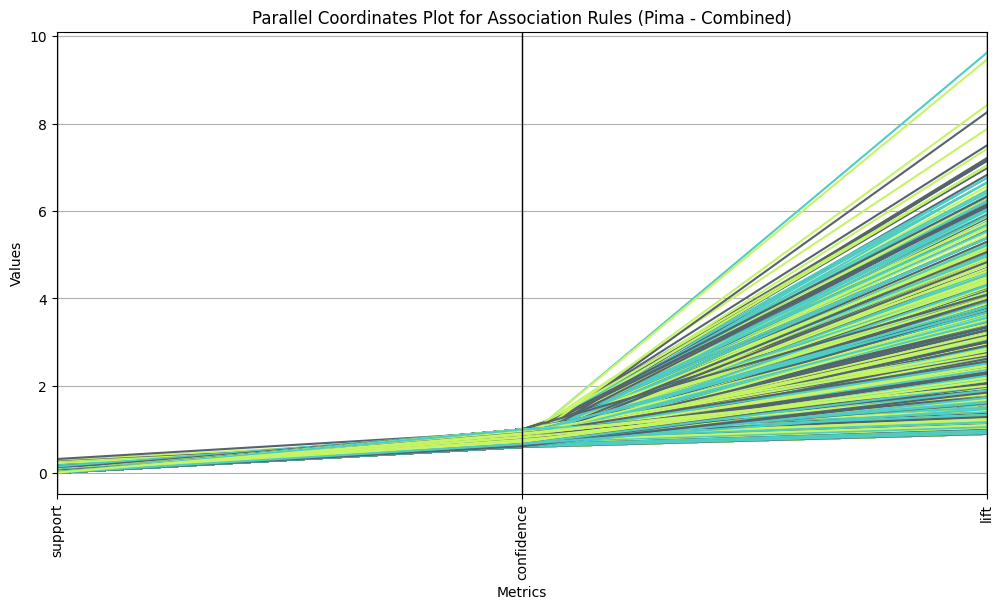

In [16]:
# ------------------------------
# 1. Combined Frequent Itemsets from Apriori and FP-Growth
# ------------------------------

print("\n--- Combined Approach on Pima Dataset ---")

# Step 1: Apply Apriori with a limited maximum itemset length (e.g., max_len=2)
frequent_itemsets_pima_apriori = apriori(pima_encoded, min_support=0.01, use_colnames=True, max_len=2)
print("Frequent itemsets (Apriori):")
print(frequent_itemsets_pima_apriori.head(10))

# Step 2: Apply FP-Growth on the same one-hot encoded data
frequent_itemsets_pima_fp = fpgrowth(pima_encoded, min_support=0.01, use_colnames=True)
print("\nFrequent itemsets (FP-Growth):")
print(frequent_itemsets_pima_fp.head(10))

# Step 3: Combine both frequent itemset DataFrames and remove duplicates
combined_frequent_itemsets_pima = pd.concat([frequent_itemsets_pima_apriori, frequent_itemsets_pima_fp]).drop_duplicates().reset_index(drop=True)

# ------------------------------
# 2. Generate Association Rules from Combined Frequent Itemsets
# ------------------------------

# The association_rules function in your version requires the number of itemsets as a parameter.
num_itemsets = len(combined_frequent_itemsets_pima)
rules_pima_combined = association_rules(combined_frequent_itemsets_pima, num_itemsets, metric="confidence", min_threshold=0.6)
print("\nTotal association rules generated (Combined):", len(rules_pima_combined))

# Filter rules: e.g., only those with lift > 1 and confidence > 0.7
filtered_rules_pima_combined = rules_pima_combined[(rules_pima_combined['lift'] > 1) & (rules_pima_combined['confidence'] > 0.7)]
sorted_rules_pima_combined = filtered_rules_pima_combined.sort_values(by='lift', ascending=False)

print("\nTop 10 Association Rules (Combined) for Pima Dataset:")
print(sorted_rules_pima_combined.head(10))

# ------------------------------
# 3. Visualize the Combined Association Rules
# ------------------------------

# 3.1 Scatter Plot: Support vs Confidence (point size = lift)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rules_pima_combined, x='support', y='confidence', 
                size='lift', sizes=(20, 200), legend=False)
plt.title('Combined Approach (Pima) - Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)
plt.show()

# 3.2 Network Graph: Visualize the Top 20 Association Rules
def draw_network_graph(rules, top_n=20):
    """
    Draws a directed network graph for the top_n association rules.
    Nodes represent items; edges (thickness based on lift) represent the rule.
    """
    G = nx.DiGraph()
    top_rules = rules.nlargest(top_n, 'lift')
    for _, row in top_rules.iterrows():
        for ant in row['antecedents']:
            for cons in row['consequents']:
                G.add_edge(ant, cons, weight=row['lift'])
    pos = nx.spring_layout(G, k=1.5, iterations=50)
    plt.figure(figsize=(12, 12))
    edges = G.edges(data=True)
    edge_weights = [edata['weight'] for _, _, edata in edges]
    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_weights, edge_cmap=plt.cm.Blues)
    plt.title("Network Graph of Top Association Rules (Pima - Combined)")
    plt.axis('off')
    plt.show()

draw_network_graph(sorted_rules_pima_combined, top_n=20)

# 3.3 Heatmap: Visualize Lift Values Between Antecedents and Consequents for Top 20 Rules
top_rules = sorted_rules_pima_combined.nlargest(20, 'lift')
# Collect unique items from antecedents and consequents
items = sorted(set(item for rule in top_rules['antecedents'] for item in rule) | 
               set(item for rule in top_rules['consequents'] for item in rule))
matrix = np.zeros((len(items), len(items)))
item_index = {item: idx for idx, item in enumerate(items)}

for _, row in top_rules.iterrows():
    for ant in row['antecedents']:
        for cons in row['consequents']:
            matrix[item_index[ant], item_index[cons]] = row['lift']

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, xticklabels=items, yticklabels=items, cmap='YlGnBu')
plt.title('Heatmap of Top Association Rules (Pima - Combined)')
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.show()

# 3.4 Parallel Coordinates Plot: Multi-Metric Comparison of Rules
parallel_data = rules_pima_combined[['antecedents','consequents','support','confidence','lift']].copy()
parallel_data['antecedents'] = parallel_data['antecedents'].apply(lambda x: ', '.join(list(x)))
parallel_data['consequents'] = parallel_data['consequents'].apply(lambda x: ', '.join(list(x)))
parallel_data['rule'] = parallel_data['antecedents'] + ' -> ' + parallel_data['consequents']

plt.figure(figsize=(12, 6))
parallel_coordinates(parallel_data, 'rule', cols=['support','confidence','lift'], 
                     color=('#556270', '#4ECDC4', '#C7F464'))
plt.title('Parallel Coordinates Plot for Association Rules (Pima - Combined)')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(rotation=90)
plt.legend([], frameon=False)
plt.show()


<h4>Combined/Hybrid Approach for Health Dataset</h4>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



--- Combined Approach on Health Dataset ---
                                             antecedents          consequents  \
5651      (Diabetes_binary, GenHlth, MentHlth, DiffWalk)   (HighBP, PhysHlth)   
5678     (Diabetes_binary, HighChol, MentHlth, DiffWalk)  (GenHlth, PhysHlth)   
5648       (Diabetes_binary, MentHlth, DiffWalk, HighBP)  (GenHlth, PhysHlth)   
5636               (Diabetes_binary, MentHlth, DiffWalk)  (GenHlth, PhysHlth)   
5172      (HighBP, HighChol, MentHlth, DiffWalk, Smoker)  (GenHlth, PhysHlth)   
12342  (HighChol, DiffWalk, HeartDiseaseorAttack, Smo...    (GenHlth, HighBP)   
12204  (PhysHlth, HighChol, DiffWalk, HeartDiseaseorA...    (GenHlth, HighBP)   
12257  (HighChol, DiffWalk, Veggies, HeartDiseaseorAt...    (GenHlth, HighBP)   
12741  (Diabetes_binary, PhysHlth, HeartDiseaseorAttack)    (GenHlth, HighBP)   
5652     (Diabetes_binary, MentHlth, DiffWalk, PhysHlth)    (GenHlth, HighBP)   

       antecedent support  consequent support   support  confid

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


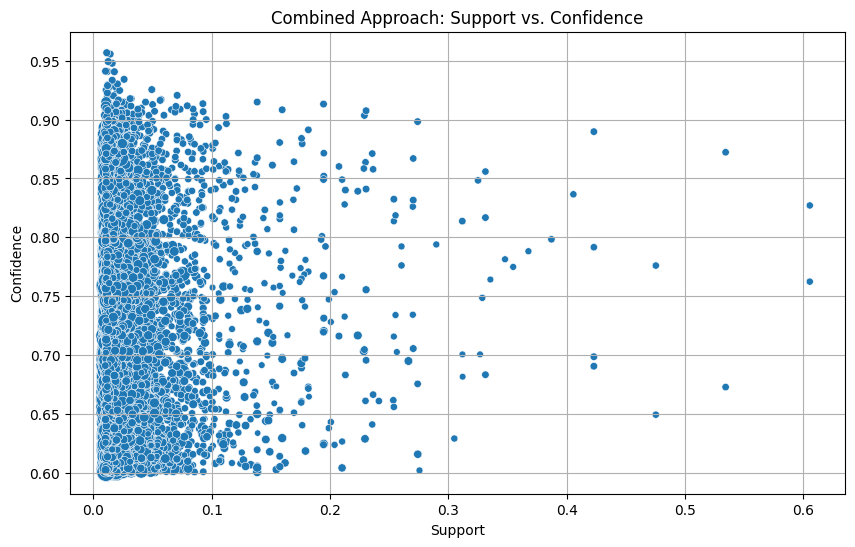

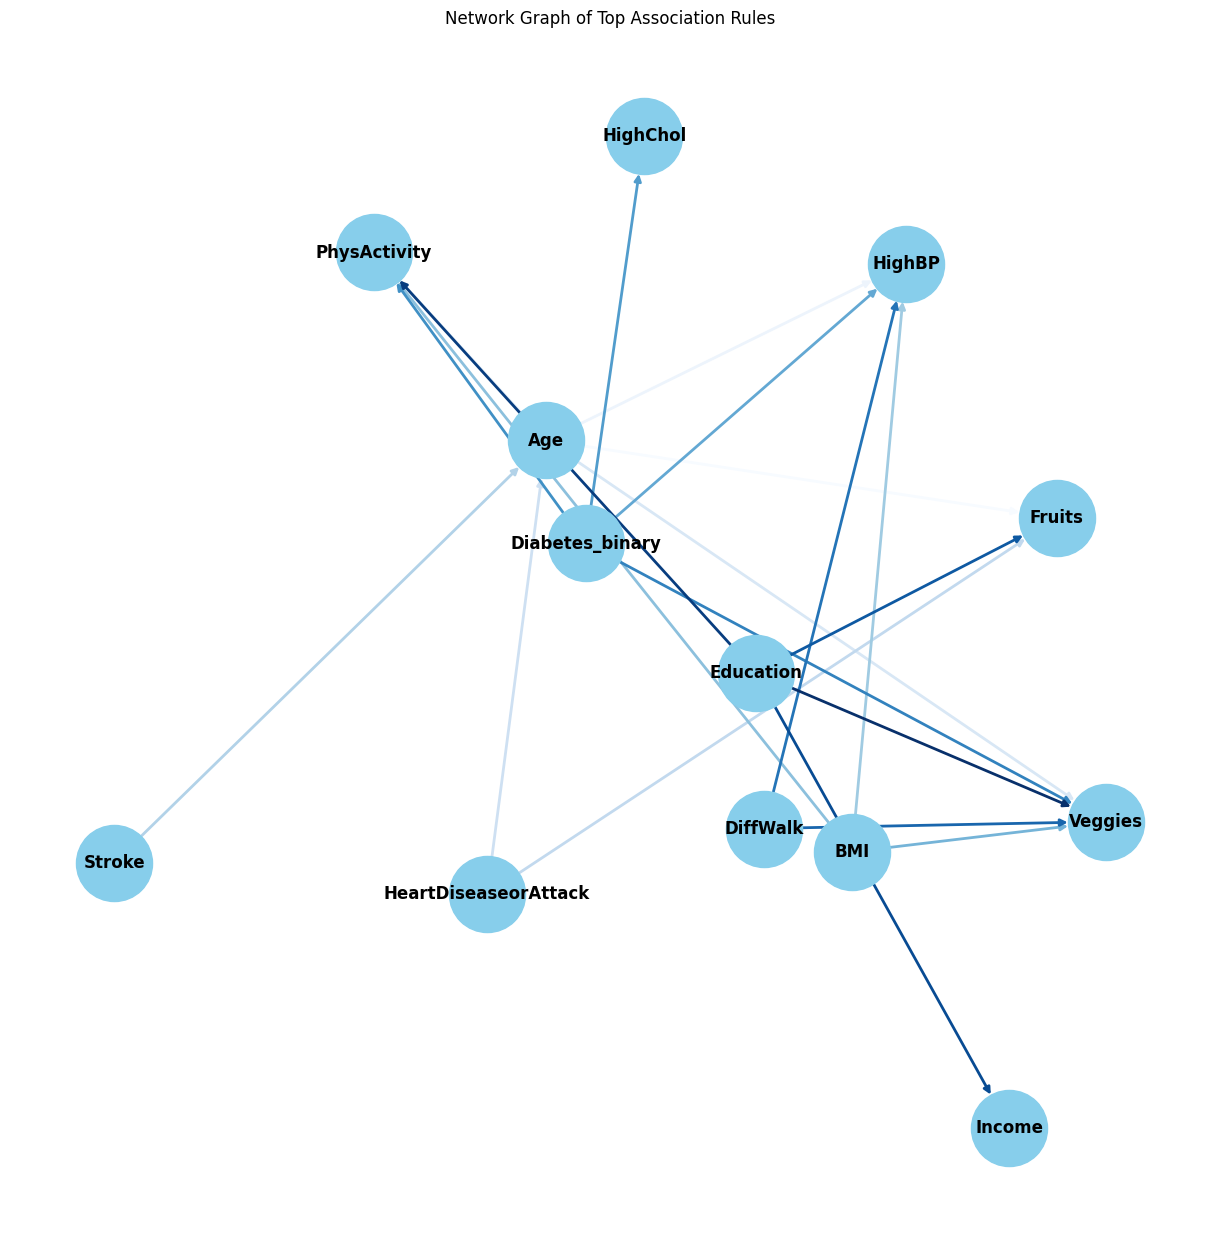

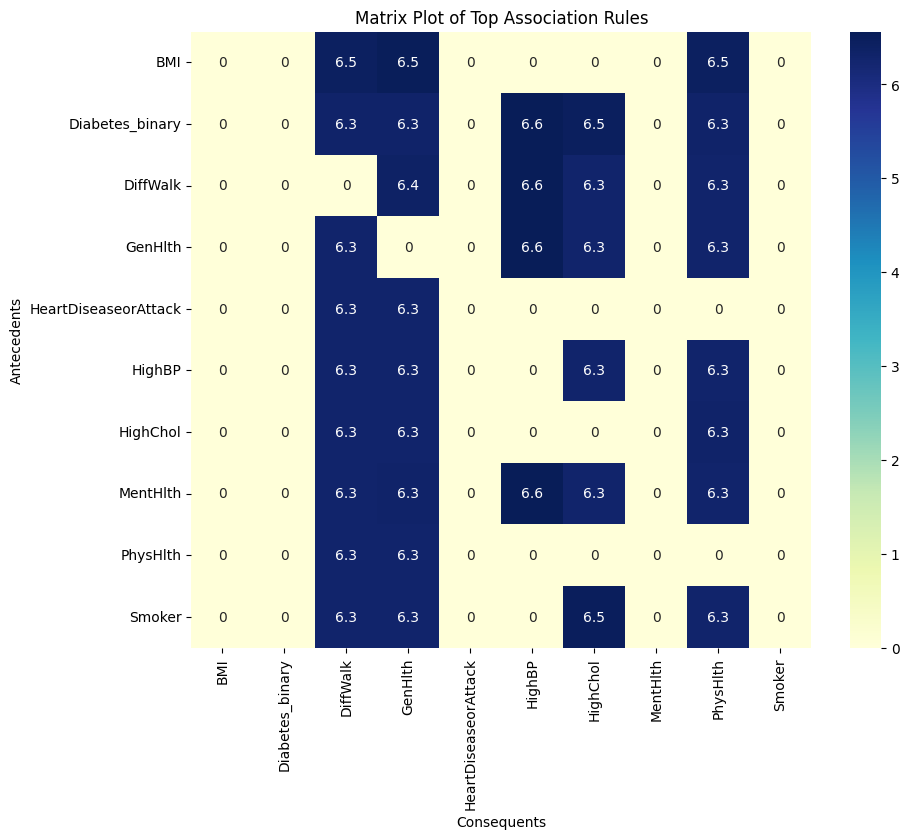

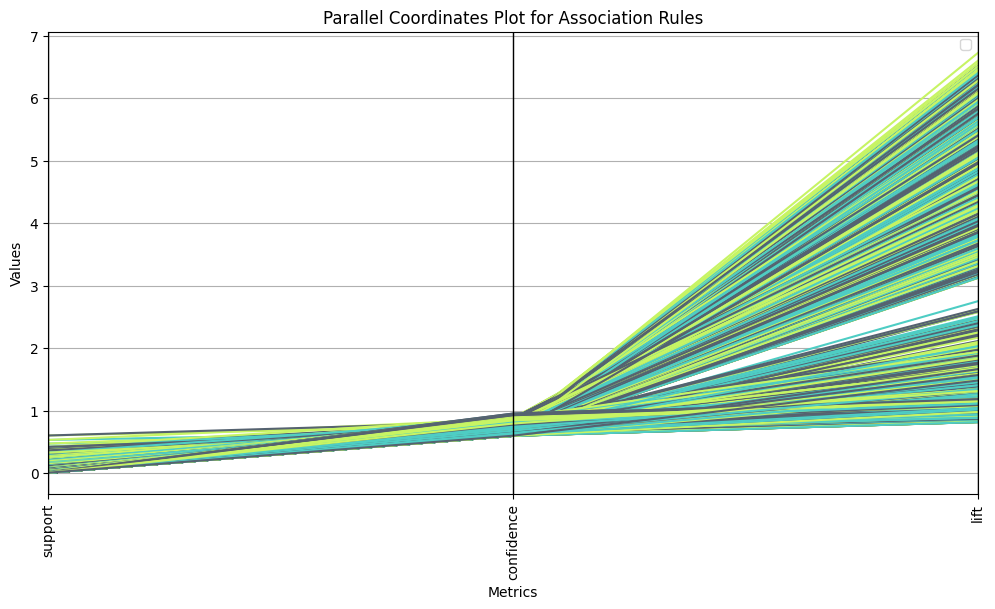

In [17]:
# --- 6.5 Combined/Hybrid Approach for Health Dataset ---
print("\n--- Combined Approach on Health Dataset ---")
# Step 1: Apriori to get frequent itemsets of limited length
frequent_itemsets_health_apriori = apriori(health_encoded, min_support=0.01, use_colnames=True, max_len=2)
# Step 2: FP-Growth on the same binarized health data
frequent_itemsets_health_fp = fpgrowth(health_encoded, min_support=0.01, use_colnames=True)
# Combine the frequent itemsets and remove duplicates
combined_frequent_itemsets = pd.concat([frequent_itemsets_health_apriori, frequent_itemsets_health_fp]).drop_duplicates().reset_index(drop=True)
# Generate association rules from the combined frequent itemsets
num_itemsets = len(combined_frequent_itemsets)
rules_combined = association_rules(combined_frequent_itemsets, num_itemsets,metric="confidence", min_threshold=0.6)
filtered_rules_combined = rules_combined[(rules_combined['lift'] > 1) & (rules_combined['confidence'] > 0.7)]
sorted_rules_combined = filtered_rules_combined.sort_values(by='lift', ascending=False)
print(sorted_rules_combined.head(10))

# Visualizations for the combined approach
plt.figure(figsize=(10, 6))
sns.scatterplot(x='support', y='confidence', size='lift', data=rules_combined, 
                legend=False, sizes=(20, 200))
plt.title('Combined Approach: Support vs. Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)
plt.show()

draw_graph(rules_combined, top_n=20)

# Heatmap of top 20 rules (by lift)
top_rules = rules_combined.nlargest(20, 'lift')
itemset = sorted(set(item for sublist in top_rules['antecedents'].tolist() 
                     + top_rules['consequents'].tolist() for item in sublist))
matrix = np.zeros((len(itemset), len(itemset)))
item_index = {item: idx for idx, item in enumerate(itemset)}
for _, rule in top_rules.iterrows():
    for antecedent in rule['antecedents']:
        for consequent in rule['consequents']:
            matrix[item_index[antecedent], item_index[consequent]] = rule['lift']

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, xticklabels=itemset, yticklabels=itemset, cmap='YlGnBu')
plt.title('Matrix Plot of Top Association Rules')
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.show()

# Parallel Coordinates Plot for association rule metrics
from pandas.plotting import parallel_coordinates
parallel_data = rules_combined[['antecedents', 'consequents', 'support', 'confidence', 'lift']].copy()
parallel_data['antecedents'] = parallel_data['antecedents'].apply(lambda x: ', '.join(list(x)))
parallel_data['consequents'] = parallel_data['consequents'].apply(lambda x: ', '.join(list(x)))
parallel_data['rule'] = parallel_data['antecedents'] + ' -> ' + parallel_data['consequents']
plt.figure(figsize=(12, 6))
parallel_coordinates(parallel_data, 'rule', cols=['support', 'confidence', 'lift'], 
                     color=('#556270', '#4ECDC4', '#C7F464'))
plt.title('Parallel Coordinates Plot for Association Rules')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.legend([])
plt.xticks(rotation=90)
plt.show()


<h4>AIS Algorithm on Pima Dataset</h4>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


One-hot encoded Pima shape: (768, 23)
Frequent Itemsets using AIS (Pima):
                                             itemsets   support
2                           [Insulin_(-0.694, 0.126]]  0.666667
8         [Pregnancies_(-1.1429999999999998, -0.548]]  0.454427
9                    [BloodPressure_(-3.574, -0.161]]  0.355469
10                    [SkinThickness_(-0.473, 0.594]]  0.351562
16                             [Age_(-1.043, -0.701]]  0.347656
13            [Glucose_(-3.7849999999999997, -0.497]]  0.343750
14                             [BMI_(-4.061, -0.393]]  0.338542
15                   [SkinThickness_(-1.289, -0.473]]  0.338542
17  [DiabetesPedigreeFunction_(-1.1909999999999998...  0.335938
19                           [Insulin_(0.126, 6.653]]  0.333333

Top 10 Association Rules (AIS) for Pima Dataset:
                                            antecedents  \
7121  (Glucose_(-3.7849999999999997, -0.497], Age_(-...   
6276  (Glucose_(0.285, 2.444], Age_(-0.701, 0.235], ..

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


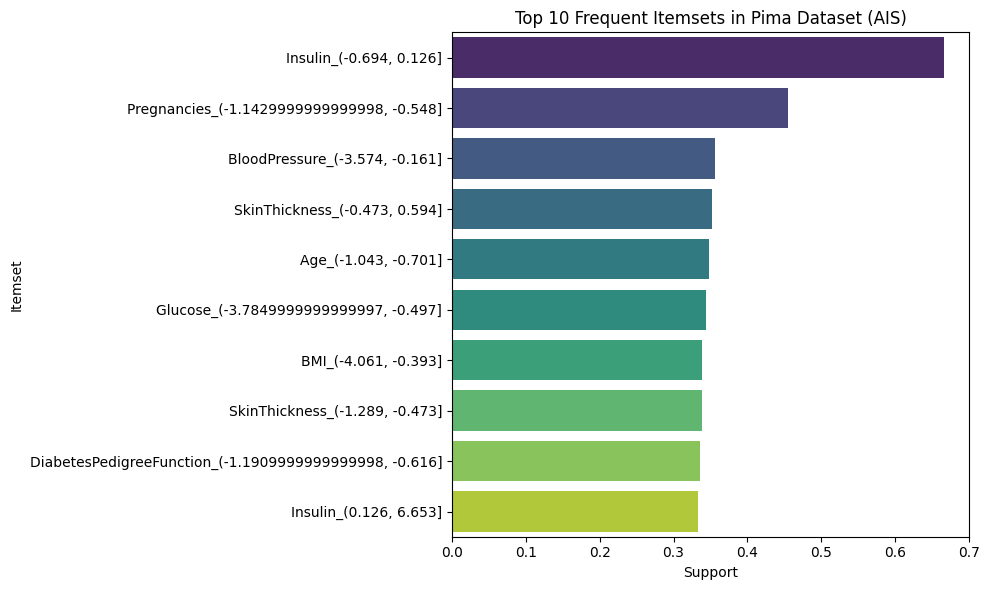

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


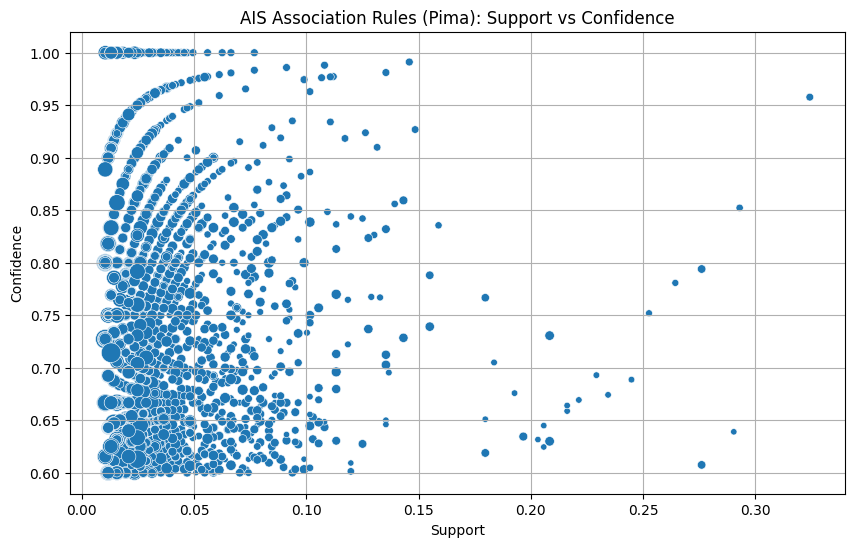

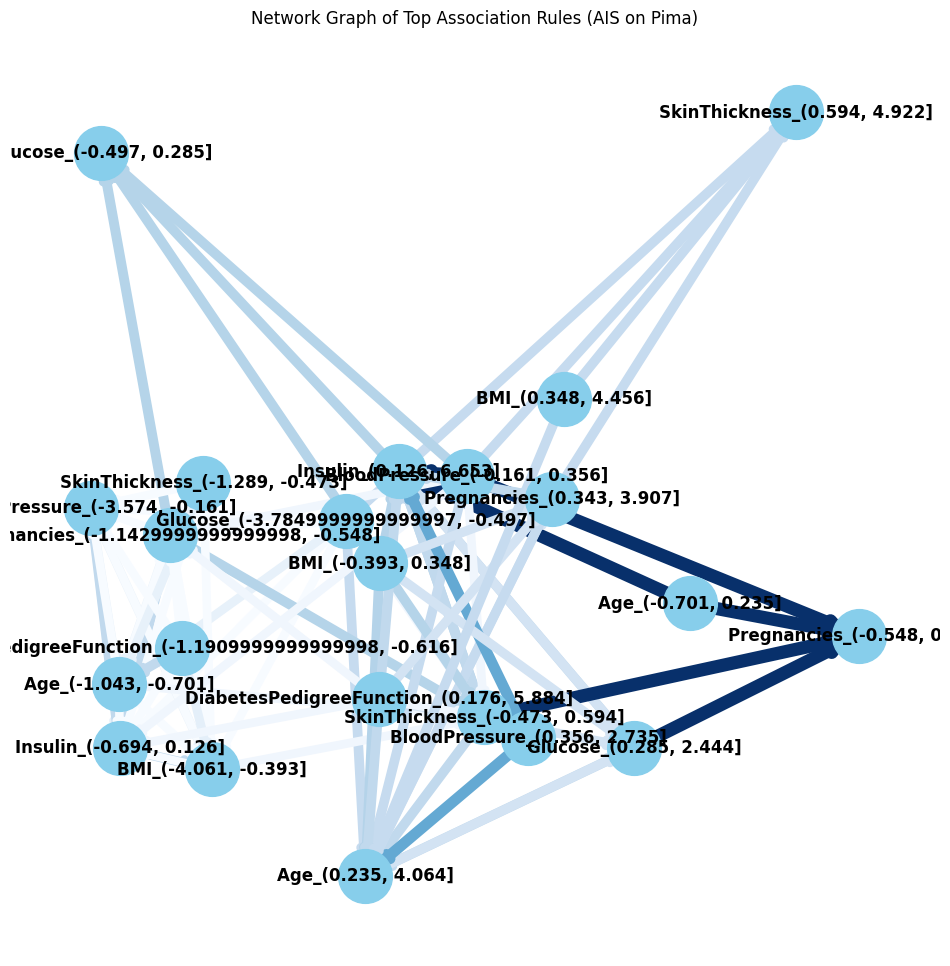

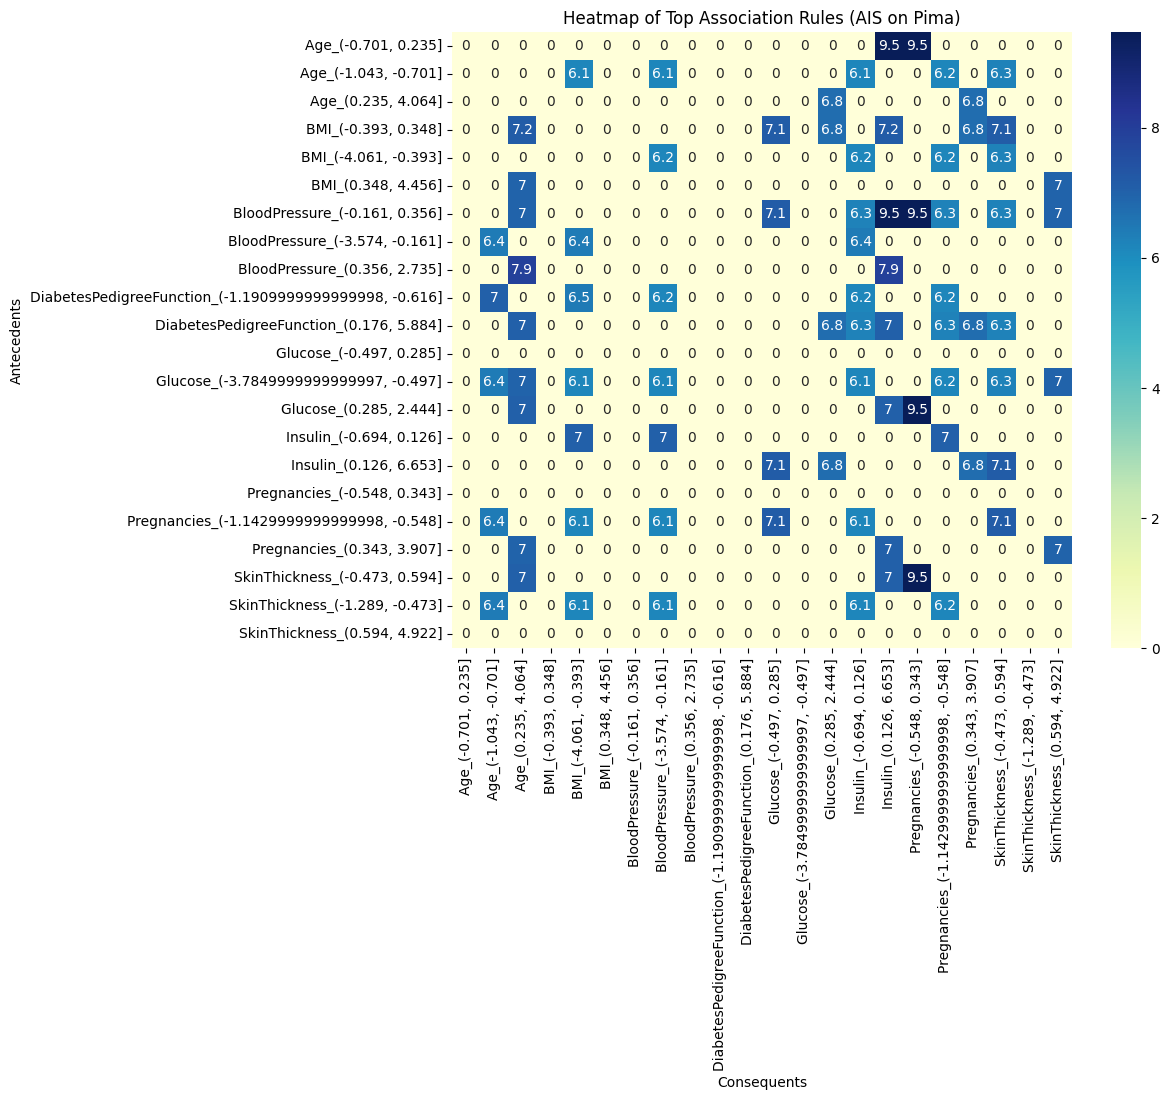

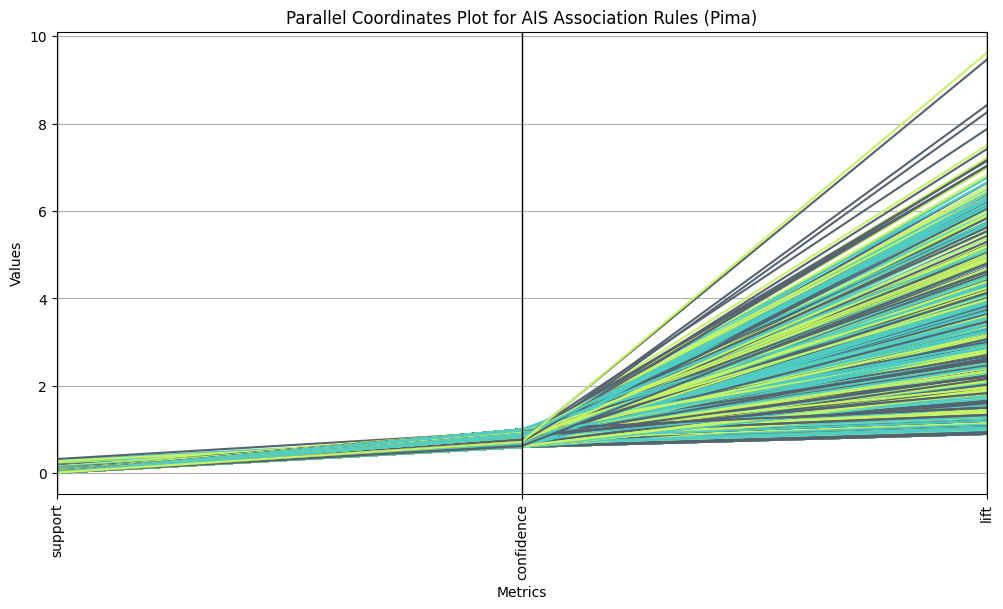

In [18]:
# ----------------------------
# Step 1: Prepare the Pima Dataset for AIS Algorithm
# ----------------------------
# Assume pima_processed is your preprocessed Pima dataset that includes the target "Outcome".
# We first convert numeric features into categorical bins.
def convert_to_categorical(df, bins=3):
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = pd.qcut(df[col], q=bins, duplicates='drop').astype(str)
    return df

# Create a categorical version of Pima data and drop the target variable.
pima_cat = convert_to_categorical(pima_processed.copy(), bins=3)
pima_cat_features = pima_cat.drop(columns=['Outcome'])

# One-hot encode the features.
pima_encoded = pd.get_dummies(pima_cat_features)
print("One-hot encoded Pima shape:", pima_encoded.shape)

# Convert each row into a set of items where the feature is active (value == 1).
transactions_pima = pima_encoded.apply(lambda row: set(row.index[row == 1]), axis=1).tolist()

# ----------------------------
# Step 2: Define and Apply the AIS Algorithm
# ----------------------------
def ais(transactions, min_support):
    """
    A simple AIS algorithm implementation.
    Parameters:
      transactions : list of sets
      min_support : float (e.g., 0.01 for 1%)
    Returns:
      Dictionary mapping frozenset of items to support.
    """
    n_transactions = len(transactions)
    frequent_itemsets = {}
    
    # First pass: count individual items
    candidate_counts = {}
    for transaction in transactions:
        for item in transaction:
            candidate = frozenset([item])
            candidate_counts[candidate] = candidate_counts.get(candidate, 0) + 1
            
    current_frequent = {itemset: count/n_transactions 
                        for itemset, count in candidate_counts.items() 
                        if count/n_transactions >= min_support}
    
    frequent_itemsets.update(current_frequent)
    
    k = 2
    current_candidates = list(current_frequent.keys())
    while current_candidates:
        new_candidate_counts = {}
        # Generate new candidate itemsets by merging current candidates
        for i in range(len(current_candidates)):
            for j in range(i+1, len(current_candidates)):
                candidate = current_candidates[i] | current_candidates[j]
                if len(candidate) == k and candidate not in new_candidate_counts:
                    count = sum(1 for transaction in transactions if candidate.issubset(transaction))
                    new_candidate_counts[candidate] = count
        new_frequent = {itemset: count/n_transactions 
                        for itemset, count in new_candidate_counts.items() 
                        if count/n_transactions >= min_support}
        if not new_frequent:
            break
        frequent_itemsets.update(new_frequent)
        current_candidates = list(new_frequent.keys())
        k += 1
    return frequent_itemsets

# Apply AIS with a minimum support threshold (adjust as needed)
min_support = 0.01  # For example, 1%
frequent_itemsets_ais = ais(transactions_pima, min_support)

# Convert AIS results to a DataFrame
results_ais = [{'itemsets': list(itemset), 'support': support} 
               for itemset, support in frequent_itemsets_ais.items()]
ais_results_df = pd.DataFrame(results_ais)
print("Frequent Itemsets using AIS (Pima):")
print(ais_results_df.sort_values(by='support', ascending=False).head(10))

# ----------------------------
# Step 3: Generate Association Rules from AIS Frequent Itemsets
# ----------------------------
# Ensure itemsets are in frozenset format
ais_results_df['itemsets'] = ais_results_df['itemsets'].apply(frozenset)
num_itemsets = len(ais_results_df)
rules_ais = association_rules(ais_results_df, num_itemsets, metric="confidence", min_threshold=0.6)
# Filter rules (e.g., lift > 1 and confidence > 0.7)
filtered_rules_ais = rules_ais[(rules_ais['lift'] > 1) & (rules_ais['confidence'] > 0.7)]
sorted_rules_ais = filtered_rules_ais.sort_values(by='lift', ascending=False)
print("\nTop 10 Association Rules (AIS) for Pima Dataset:")
print(sorted_rules_ais.head(10))

# ----------------------------
# Step 4: Visualize the Results
# ----------------------------

# 4.1 Bar Chart of Top Frequent Itemsets (AIS)
ais_results_df['itemset_str'] = ais_results_df['itemsets'].apply(lambda x: ', '.join(sorted(x)))
top_itemsets_ais = ais_results_df.sort_values(by='support', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_itemsets_ais, x='support', y='itemset_str', palette='viridis')
plt.title("Top 10 Frequent Itemsets in Pima Dataset (AIS)")
plt.xlabel("Support")
plt.ylabel("Itemset")
plt.tight_layout()
plt.show()

# 4.2 Scatter Plot: Association Rules (Support vs Confidence)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rules_ais, x='support', y='confidence', 
                size='lift', sizes=(20, 200), legend=False)
plt.title('AIS Association Rules (Pima): Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)
plt.show()

# 4.3 Network Graph of Top 20 Association Rules (AIS)
def draw_network_graph(rules, top_n=20):
    G = nx.DiGraph()
    top_rules = rules.nlargest(top_n, 'lift')
    for _, row in top_rules.iterrows():
        for ant in row['antecedents']:
            for cons in row['consequents']:
                G.add_edge(ant, cons, weight=row['lift'])
    pos = nx.spring_layout(G, k=1.5, iterations=50)
    plt.figure(figsize=(12, 12))
    edges = G.edges(data=True)
    edge_weights = [edata['weight'] for _, _, edata in edges]
    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_weights, edge_cmap=plt.cm.Blues)
    plt.title("Network Graph of Top Association Rules (AIS on Pima)")
    plt.axis('off')
    plt.show()

draw_network_graph(sorted_rules_ais, top_n=20)

# 4.4 Heatmap of Top 20 Association Rules (AIS)
top_rules = sorted_rules_ais.nlargest(20, 'lift')
items = sorted(set(item for rule in top_rules['antecedents'] for item in rule) | 
               set(item for rule in top_rules['consequents'] for item in rule))
matrix = np.zeros((len(items), len(items)))
item_index = {item: idx for idx, item in enumerate(items)}
for _, row in top_rules.iterrows():
    for ant in row['antecedents']:
        for cons in row['consequents']:
            matrix[item_index[ant], item_index[cons]] = row['lift']
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, xticklabels=items, yticklabels=items, cmap='YlGnBu')
plt.title('Heatmap of Top Association Rules (AIS on Pima)')
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.show()

# 4.5 Parallel Coordinates Plot for Association Rule Metrics (AIS)
parallel_data = rules_ais[['antecedents','consequents','support','confidence','lift']].copy()
parallel_data['antecedents'] = parallel_data['antecedents'].apply(lambda x: ', '.join(list(x)))
parallel_data['consequents'] = parallel_data['consequents'].apply(lambda x: ', '.join(list(x)))
parallel_data['rule'] = parallel_data['antecedents'] + ' -> ' + parallel_data['consequents']
plt.figure(figsize=(12, 6))
parallel_coordinates(parallel_data, 'rule', cols=['support','confidence','lift'], 
                     color=('#556270', '#4ECDC4', '#C7F464'))
plt.title('Parallel Coordinates Plot for AIS Association Rules (Pima)')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(rotation=90)
plt.legend([], frameon=False)
plt.show()


<h4>AIS Algorithm on Health Dataset</h4>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Frequent Itemsets using AIS (Health Dataset):
                    itemsets   support
6                  [Veggies]  0.794026
9             [PhysActivity]  0.731889
13                  [Fruits]  0.612415
117  [Veggies, PhysActivity]  0.605331
121        [Veggies, Fruits]  0.534196
12                  [Income]  0.484810
153   [PhysActivity, Fruits]  0.475239
7                   [Smoker]  0.466360
0                   [HighBP]  0.457737
1                 [HighChol]  0.445123

Top 10 Association Rules (AIS) for Health Dataset:
                                             antecedents          consequents  \
10569     (Diabetes_binary, GenHlth, MentHlth, DiffWalk)   (HighBP, PhysHlth)   
11734    (Diabetes_binary, HighChol, MentHlth, DiffWalk)  (GenHlth, PhysHlth)   
10566      (Diabetes_binary, MentHlth, DiffWalk, HighBP)  (GenHlth, PhysHlth)   
7387               (Diabetes_binary, MentHlth, DiffWalk)  (GenHlth, PhysHlth)   
13024     (HighBP, HighChol, MentHlth, DiffWalk, Smoker)  (GenHlth, 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


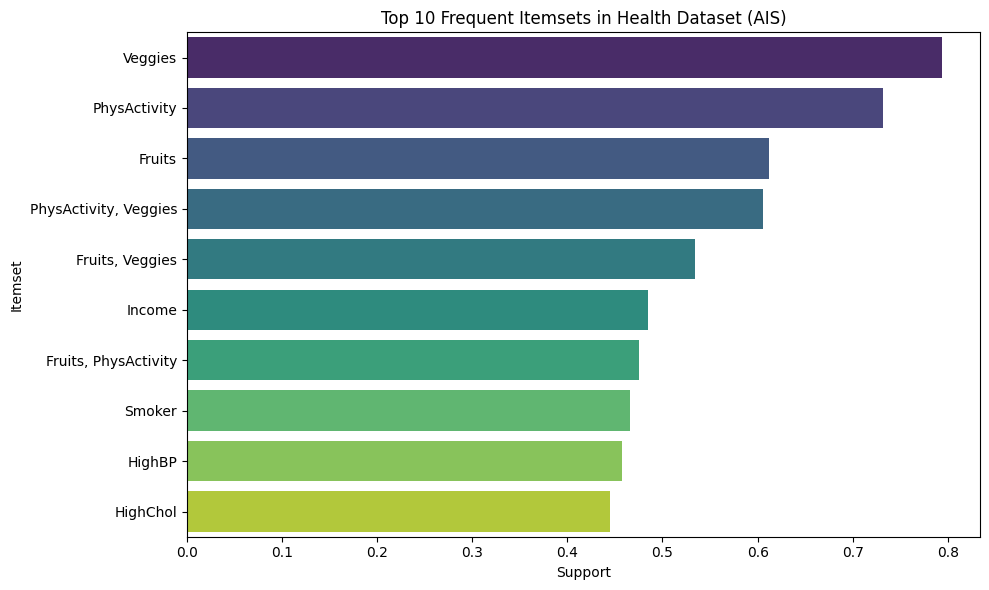

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


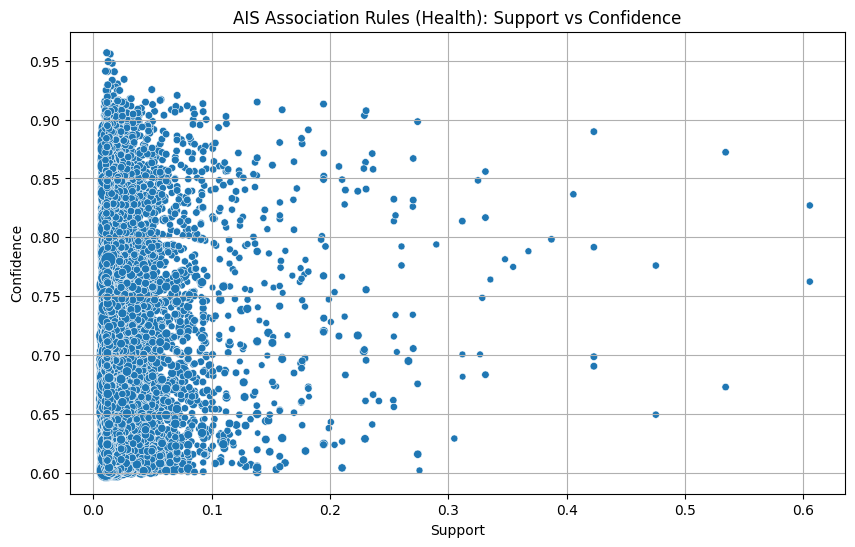

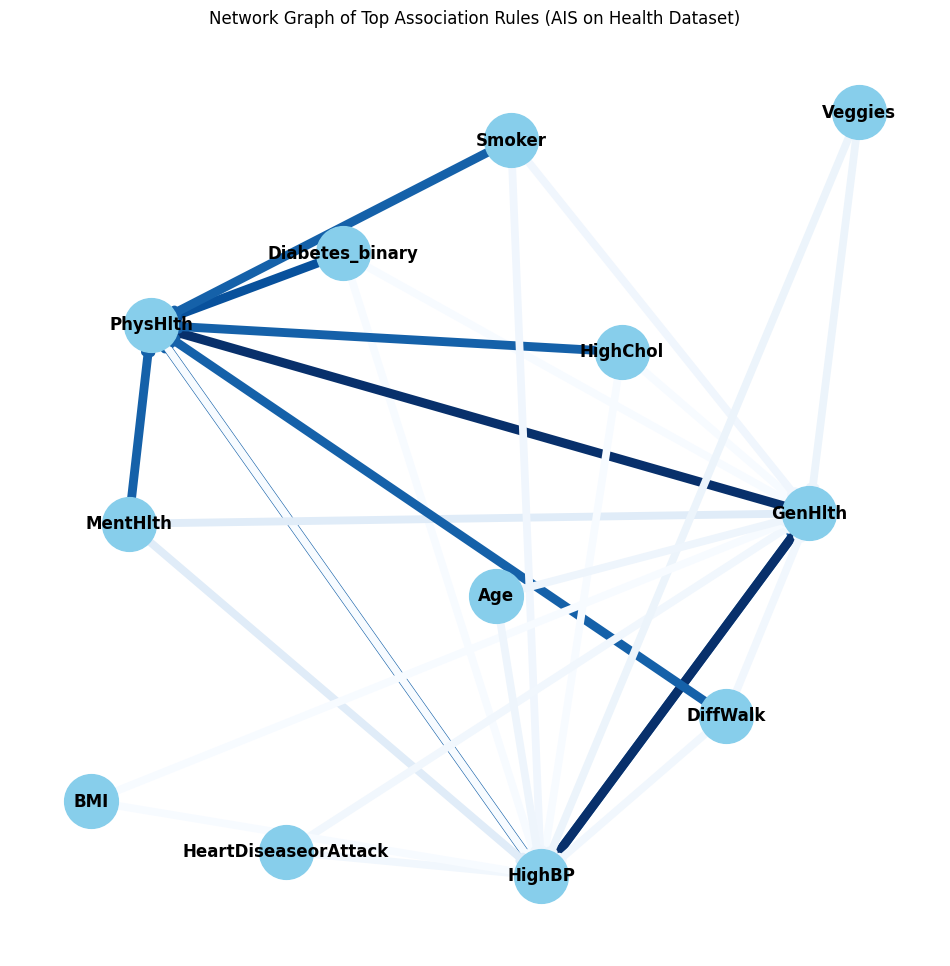

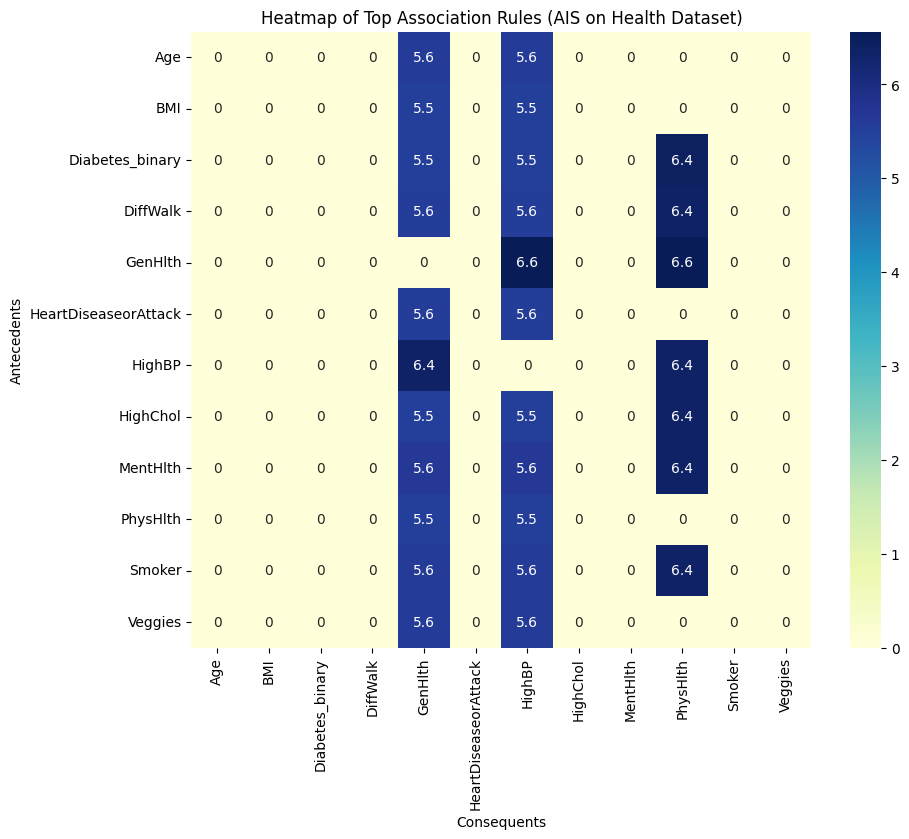

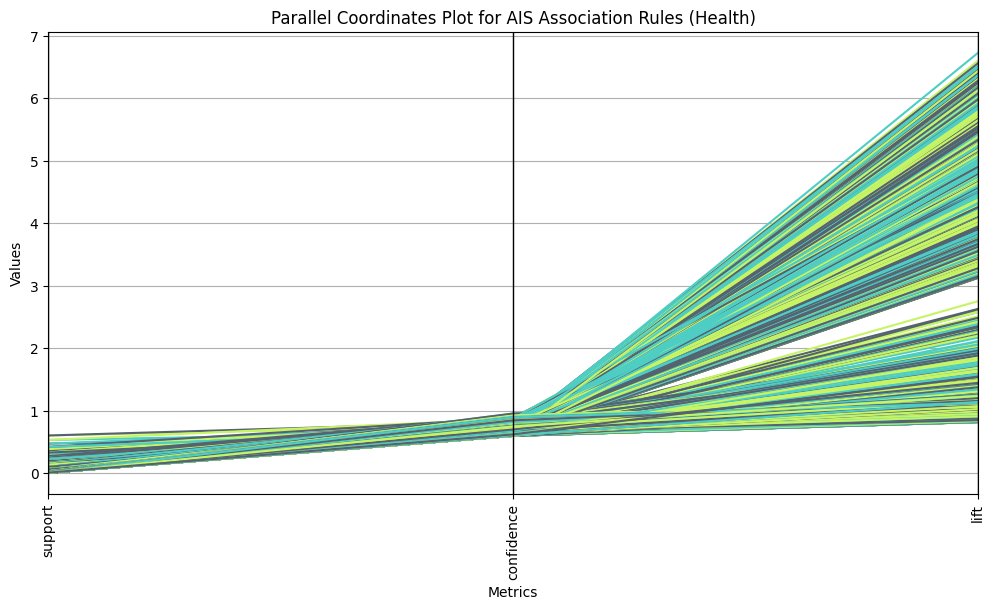

In [19]:
# ----------------------------------------
# Step 1: Convert the One-Hot Encoded Health Data into Transactions
# ----------------------------------------
# Assuming health_encoded is your one-hot encoded DataFrame (with 0/1 values)
# Each row represents a transaction. We convert each row into a set of items where the value is 1.
transactions_health = health_encoded.apply(lambda row: set(row.index[row == 1]), axis=1).tolist()

# ----------------------------------------
# Step 2: Define the AIS Algorithm Function
# ----------------------------------------
def ais(transactions, min_support):
    """
    A simple AIS algorithm implementation.
    
    Parameters:
      transactions : list of sets (each transaction as a set of items)
      min_support : float (e.g., 0.01 for 1%)
    
    Returns:
      Dictionary mapping frozenset of items to their support (as a fraction).
    """
    n_transactions = len(transactions)
    frequent_itemsets = {}
    
    # First pass: count individual items
    candidate_counts = {}
    for transaction in transactions:
        for item in transaction:
            candidate = frozenset([item])
            candidate_counts[candidate] = candidate_counts.get(candidate, 0) + 1
    current_frequent = {itemset: count / n_transactions
                        for itemset, count in candidate_counts.items()
                        if count / n_transactions >= min_support}
    frequent_itemsets.update(current_frequent)
    
    k = 2
    current_candidates = list(current_frequent.keys())
    while current_candidates:
        new_candidate_counts = {}
        # Generate new candidate itemsets by merging current candidates
        for i in range(len(current_candidates)):
            for j in range(i + 1, len(current_candidates)):
                candidate = current_candidates[i] | current_candidates[j]
                if len(candidate) == k and candidate not in new_candidate_counts:
                    count = sum(1 for transaction in transactions if candidate.issubset(transaction))
                    new_candidate_counts[candidate] = count
        new_frequent = {itemset: count / n_transactions
                        for itemset, count in new_candidate_counts.items()
                        if count / n_transactions >= min_support}
        if not new_frequent:
            break
        frequent_itemsets.update(new_frequent)
        current_candidates = list(new_frequent.keys())
        k += 1
    return frequent_itemsets

# ----------------------------------------
# Step 3: Run AIS on the Health Dataset
# ----------------------------------------
min_support = 0.01  # Set as needed (here 1%)
frequent_itemsets_ais = ais(transactions_health, min_support)

# Convert the frequent itemsets dictionary into a DataFrame for easier viewing
results_ais = [{'itemsets': list(itemset), 'support': support} 
               for itemset, support in frequent_itemsets_ais.items()]
ais_results_df = pd.DataFrame(results_ais)
print("Frequent Itemsets using AIS (Health Dataset):")
print(ais_results_df.sort_values(by='support', ascending=False).head(10))

# ----------------------------------------
# Step 4: Generate Association Rules from AIS Frequent Itemsets
# ----------------------------------------
# Ensure the 'itemsets' column is in frozenset format
ais_results_df['itemsets'] = ais_results_df['itemsets'].apply(frozenset)
num_itemsets = len(ais_results_df)
rules_ais = association_rules(ais_results_df, num_itemsets, metric="confidence", min_threshold=0.6)

# Filter the rules (for example, keeping those with lift > 1 and confidence > 0.7)
filtered_rules_ais = rules_ais[(rules_ais['lift'] > 1) & (rules_ais['confidence'] > 0.7)]
sorted_rules_ais = filtered_rules_ais.sort_values(by='lift', ascending=False)
print("\nTop 10 Association Rules (AIS) for Health Dataset:")
print(sorted_rules_ais.head(10))

# ----------------------------------------
# Step 5: Visualize the Results
# ----------------------------------------

# 5.1 Bar Chart: Top Frequent Itemsets from AIS
ais_results_df['itemset_str'] = ais_results_df['itemsets'].apply(lambda x: ', '.join(sorted(x)))
top_itemsets_ais = ais_results_df.sort_values(by='support', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(data=top_itemsets_ais, x='support', y='itemset_str', palette='viridis')
plt.title("Top 10 Frequent Itemsets in Health Dataset (AIS)")
plt.xlabel("Support")
plt.ylabel("Itemset")
plt.tight_layout()
plt.show()

# 5.2 Scatter Plot: Association Rules (Support vs Confidence)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rules_ais, x='support', y='confidence', size='lift', sizes=(20, 200), legend=False)
plt.title('AIS Association Rules (Health): Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)
plt.show()

# 5.3 Network Graph: Top 20 Association Rules
def draw_network_graph(rules, top_n=20):
    G = nx.DiGraph()
    top_rules = rules.nlargest(top_n, 'lift')
    for _, row in top_rules.iterrows():
        for ant in row['antecedents']:
            for cons in row['consequents']:
                G.add_edge(ant, cons, weight=row['lift'])
    pos = nx.spring_layout(G, k=1.5, iterations=50)
    plt.figure(figsize=(12, 12))
    edges = G.edges(data=True)
    edge_weights = [edata['weight'] for _, _, edata in edges]
    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_weights, edge_cmap=plt.cm.Blues)
    plt.title("Network Graph of Top Association Rules (AIS on Health Dataset)")
    plt.axis('off')
    plt.show()

draw_network_graph(sorted_rules_ais, top_n=20)

# 5.4 Heatmap: Lift Values Between Antecedents and Consequents for Top 20 Rules
top_rules = sorted_rules_ais.nlargest(20, 'lift')
unique_items = sorted(set(item for rule in top_rules['antecedents'] for item in rule) |
                      set(item for rule in top_rules['consequents'] for item in rule))
matrix = np.zeros((len(unique_items), len(unique_items)))
item_index = {item: idx for idx, item in enumerate(unique_items)}
for _, row in top_rules.iterrows():
    for ant in row['antecedents']:
        for cons in row['consequents']:
            matrix[item_index[ant], item_index[cons]] = row['lift']
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, xticklabels=unique_items, yticklabels=unique_items, cmap='YlGnBu')
plt.title('Heatmap of Top Association Rules (AIS on Health Dataset)')
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.show()

# 5.5 Parallel Coordinates Plot: Rule Metrics
parallel_data = rules_ais[['antecedents', 'consequents', 'support', 'confidence', 'lift']].copy()
parallel_data['antecedents'] = parallel_data['antecedents'].apply(lambda x: ', '.join(sorted(x)))
parallel_data['consequents'] = parallel_data['consequents'].apply(lambda x: ', '.join(sorted(x)))
parallel_data['rule'] = parallel_data['antecedents'] + ' -> ' + parallel_data['consequents']
plt.figure(figsize=(12, 6))
parallel_coordinates(parallel_data, 'rule', cols=['support', 'confidence', 'lift'], 
                     color=('#556270', '#4ECDC4', '#C7F464'))
plt.title('Parallel Coordinates Plot for AIS Association Rules (Health)')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(rotation=90)
plt.legend([], frameon=False)
plt.show()
